In [1037]:
import pandas as pd
import numpy as np
import seaborn as sns
from pyspark.sql import SparkSession

# instantiate SparkSession object
# spark = SparkSession.builder.master('local').getOrCreate()

spark = SparkSession\
        .builder\
        .appName('ALSExample').config('spark.driver.host', 'localhost')\
        .getOrCreate()

In [1038]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row
import pyspark as spark
spark = SparkSession.builder.appName('Recommendation_system').getOrCreate()
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.sql.functions import col

In [1027]:
reviews = pd.read_csv('../../data/raw/ratings.csv')
links = pd.read_csv('../../data/raw/links.csv')
movies = pd.read_csv('../../data/raw/movies.csv')
tags = pd.read_csv('../../data/raw/tags.csv')

In [957]:
movies.head(10)

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]
5,6,Heat (1995),"[Action, Crime, Thriller]"
6,7,Sabrina (1995),"[Comedy, Romance]"
7,8,Tom and Huck (1995),"[Adventure, Children]"
8,9,Sudden Death (1995),[Action]
9,10,GoldenEye (1995),"[Action, Adventure, Thriller]"


In [958]:
reviews.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


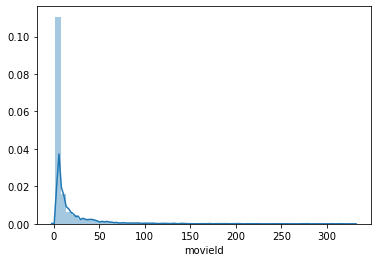

In [11]:
sns.distplot(reviews.movieId.value_counts())

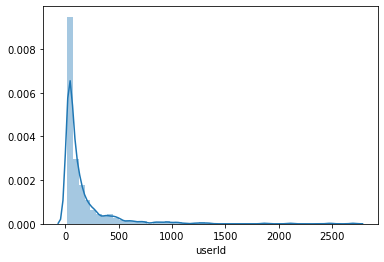

In [13]:
sns.distplot(reviews.userId.value_counts())

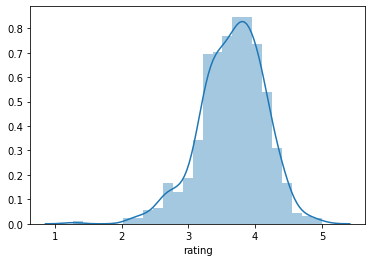

In [15]:
sns.distplot(reviews.groupby('userId')['rating'].mean())

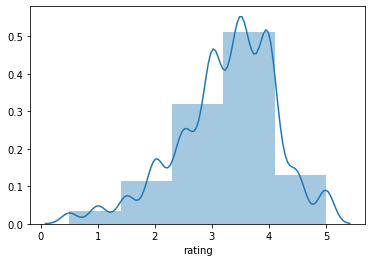

In [23]:
sns.distplot(reviews.groupby('movieId')['rating'].mean(),bins=5)

In [1039]:
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [289]:
movies['genres'] = movies['genres'].apply(lambda x: x.split('|'))

# Spark ALS Model

In [1102]:
movie_ratings = spark.read.csv('../../data/raw/ratings.csv', header='true', inferSchema='true')
movie_ratings = movie_ratings.drop('timestamp')

In [1120]:
training

DataFrame[userId: int, movieId: int, rating: double]

In [1118]:
# split into training and testing sets
(training, test) = movie_ratings.randomSplit([0.8, 0.2])

# Build the recommendation model using ALS on the training data
# Note we set cold start strategy to 'drop' to ensure we don't get NaN evaluation metrics
als = ALS(maxIter=5,rank=4, regParam=0.01, userCol='userId', itemCol='movieId', ratingCol='rating',
          coldStartStrategy='drop')

# fit the ALS model to the training set
model = als.fit(training)

In [8]:
# Evaluate the model by computing the RMSE on the test data
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName='rmse', labelCol='rating',
                                predictionCol='prediction')
rmse = evaluator.evaluate(predictions)
print('Root-mean-square error = ' + str(rmse))

Root-mean-square error = 0.9816401507879539


In [1042]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [10]:
# initialize the ALS model
als_model = ALS(userCol='userId', itemCol='movieId', 
                ratingCol='rating', coldStartStrategy='drop')

# create the parameter grid                 
params = ParamGridBuilder()\
          .addGrid(als_model.regParam, [0.01, 0.001, 0.1])\
          .addGrid(als_model.rank, [4, 10, 50]).build()


# instantiating crossvalidator estimator
cv = CrossValidator(estimator=als_model, estimatorParamMaps=params,evaluator=evaluator,parallelism=4)
best_model = cv.fit(movie_ratings)    

# We see the best model has a rank of 50, so we will use that in our future models with this dataset
best_model.bestModel.rank

4

In [1043]:
def new_user_recs(user_id, new_ratings, rating_df, movie_title_df, num_recs):
    # turn the new_recommendations list into a spark DataFrame
    movie_id_list = []
    new_user_ratings = spark.createDataFrame(new_ratings,rating_df.columns)
    
    # combine the new ratings df with the rating_df
    movie_ratings_combined = rating_df.union(new_user_ratings)
    
    # split the dataframe into a train and test set
#     (training, test) = movie_ratings_combined.randomSplit([0.8, 0.2],seed=0)
    
    # create an ALS model and fit it
    als = ALS(maxIter=5, rank=50, regParam=0.01, userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop")
    model = als.fit(movie_ratings_combined)
    
    # make recommendations for all users using the recommendForAllUsers method
    recommendations = model.recommendForAllUsers(num_recs)
    
    # get recommendations specifically for the new user that has been added to the DataFrame
    recs_for_user = recommendations.where(recommendations.userId == user_id).take(1)
    
    for ranking, (movie_id, rating) in enumerate(recs_for_user[0]['recommendations']):
        movie_string = name_retriever(movie_id, movie_title_df)
        movie_id_list.append(movie_id)
        print(movie_id)
        print('Recommendation {}: {}  | predicted score :{}'.format(ranking+1, movie_string, rating))
        
    return movie_id_list

In [1044]:
def name_retriever(movie_id, movie_title_df):
    return movie_title_df.where(movie_title_df.movieId == movie_id).take(1)[0]['title']

In [1045]:
movie_titles = spark.read.csv('../../data/raw/movies.csv', header='true', inferSchema='true')

In [1046]:
movies[(movies['movieId']==9692)]

,movieId,title,genres


In [1051]:
# try out your function with the movies listed above
user_id = 1000
user_ratings_1 = [(user_id,3257,5),
                  (user_id,2459,1),
                  (user_id,2513,2),
                  (user_id,6502,2),
                  (user_id,1091,2),
                  (user_id,441,4)]
new_user_recs(user_id,
             new_ratings=user_ratings_1,
             rating_df=movie_ratings,
             movie_title_df = movie_titles ,
             num_recs = 10)

3257
Recommendation 1: Bodyguard, The (1992)  | predicted score :4.987308025360107
2423
Recommendation 2: Christmas Vacation (National Lampoon's Christmas Vacation) (1989)  | predicted score :4.203624725341797
920
Recommendation 3: Gone with the Wind (1939)  | predicted score :4.146108627319336
357
Recommendation 4: Four Weddings and a Funeral (1994)  | predicted score :4.0790863037109375
6942
Recommendation 5: Love Actually (2003)  | predicted score :4.075046539306641
1172
Recommendation 6: Cinema Paradiso (Nuovo cinema Paradiso) (1989)  | predicted score :4.0314764976501465
260
Recommendation 7: Star Wars: Episode IV - A New Hope (1977)  | predicted score :4.017823696136475
830
Recommendation 8: First Wives Club, The (1996)  | predicted score :4.010028839111328
441
Recommendation 9: Dazed and Confused (1993)  | predicted score :3.998265504837036
119145
Recommendation 10: Kingsman: The Secret Service (2015)  | predicted score :3.9860315322875977


[3257, 2423, 920, 357, 6942, 1172, 260, 830, 441, 119145]

# Making movie content filtering system

In [1052]:
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate

In [1173]:
movies = pd.read_csv('../../data/raw/movies.csv')

In [1174]:
movies['year'] = movies['title'].apply(lambda x: x[-5:-1].strip('('))
movies['year'] = movies['year'].apply(lambda x: x.strip(')'))
movies['year'] = movies['year'].apply(lambda x: x.strip('-'))
movies = movies.drop(movies[movies['title'].str.contains("\(") == False].index)

In [1058]:
from sklearn.preprocessing import MultiLabelBinarizer

In [1059]:
mlb = MultiLabelBinarizer()

res = pd.DataFrame(mlb.fit_transform(movies['genres']),
                   columns=mlb.classes_,
                   index=movies['genres'].index)

In [1060]:
genre_reviews = pd.merge(movies, res, left_index = True, right_index = True)

In [1063]:
genre_reviews = genre_reviews.drop(['genres'], axis = 1)

In [1064]:
## how do we deal with these??
genre_reviews.loc[genre_reviews['(no genres listed)'] == True]

KeyError: '(no genres listed)'

In [1065]:
tags = pd.read_csv('../../data/raw/tags.csv')

In [1066]:
tags['joined_tags'] = tags.groupby('movieId')['tag'].transform(lambda x: ' '.join(x))

In [1067]:
tags

,userId,movieId,tag,timestamp,joined_tags
0,2,60756,funny,1445714994,funny Highly quotable will ferrell comedy funn...
1,2,60756,Highly quotable,1445714996,funny Highly quotable will ferrell comedy funn...
2,2,60756,will ferrell,1445714992,funny Highly quotable will ferrell comedy funn...
3,2,89774,Boxing story,1445715207,Boxing story MMA Tom Hardy
4,2,89774,MMA,1445715200,Boxing story MMA Tom Hardy
...,...,...,...,...,...
3678,606,7382,for katie,1171234019,adolescence crime for katie
3679,606,7936,austere,1173392334,austere
3680,610,3265,gun fu,1493843984,gun fu heroic bloodshed
3681,610,3265,heroic bloodshed,1493843978,gun fu heroic bloodshed


In [1068]:
tags = tags[['movieId', 'joined_tags']].drop_duplicates()

In [1069]:
tags

,movieId,joined_tags
0,60756,funny Highly quotable will ferrell comedy funn...
3,89774,Boxing story MMA Tom Hardy
6,106782,drugs Leonardo DiCaprio Martin Scorsese Stock ...
9,48516,way too long Leonardo DiCaprio suspense twist ...
10,431,Al Pacino gangster mafia
...,...,...
3674,1948,British
3676,5694,70mm
3677,6107,World War II
3679,7936,austere


In [1070]:
tags.loc[tags.movieId == 1]

,movieId,joined_tags
629,1,pixar pixar fun


In [1071]:
avg_review = pd.DataFrame(reviews.groupby('movieId')['rating'].mean())

In [1072]:
avg_review['no_of_ratings'] = reviews.groupby('movieId')['rating'].count()

In [1073]:
movies_ratings = genre_reviews.merge(avg_review, how = 'inner', on = 'movieId')

In [1074]:
movies_ratings

,movieId,title,year,,(,),-,A,C,D,...,o,r,s,t,u,v,y,|,rating,no_of_ratings
0,1,Toy Story (1995),1995,0,0,0,0,1,1,0,...,1,1,1,1,1,1,1,1,3.920930,215
1,2,Jumanji (1995),1995,0,0,0,0,1,1,0,...,0,1,1,1,1,1,1,1,3.431818,110
2,3,Grumpier Old Men (1995),1995,0,0,0,0,0,1,0,...,1,0,0,0,0,0,1,1,3.259615,52
3,4,Waiting to Exhale (1995),1995,0,0,0,0,0,1,1,...,1,1,0,0,0,0,1,1,2.357143,7
4,5,Father of the Bride Part II (1995),1995,0,0,0,0,0,1,0,...,1,0,0,0,0,0,1,0,3.071429,49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9707,193581,Black Butler: Book of the Atlantic (2017),2017,0,0,0,0,1,1,0,...,1,0,1,1,0,0,1,1,4.000000,1
9708,193583,No Game No Life: Zero (2017),2017,0,0,0,0,1,1,0,...,1,0,1,1,0,0,1,1,3.500000,1
9709,193585,Flint (2017),2017,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,3.500000,1
9710,193587,Bungo Stray Dogs: Dead Apple (2018),2018,0,0,0,0,1,0,0,...,1,0,0,1,0,0,0,1,3.500000,1


# NLTK

In [1075]:
from nltk import *
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from rake_nltk import Rake

ModuleNotFoundError: No module named 'rake_nltk'

In [1076]:
movies_w_tags['joined_tags'] = movies_w_tags['joined_tags'].apply(lambda x: x.replace(',', ''))

KeyError: 'joined_tags'

In [391]:
def combine_tags_genres(movies, tags):
    df = movies.merge(tags, on='movieId', how='outer')
    df['genres'] = df['genres'].apply(lambda x: ' '.join([str(elem) for elem in x]) )
    df = df[df['title'].isna()==False]
    df.loc[df['joined_tags'].isnull(),['joined_tags']] = df.loc[df['joined_tags'].isnull(),'joined_tags'].apply(lambda x:[])

    df['keywords'] = df['genres'] +' '+ df['joined_tags'].map(str)
    df = df.drop(['joined_tags'], axis=1)
    df['genres'] = df['genres'].apply(lambda x: x.split(' '))
    
    
    return df

In [392]:
movies_w_tags = combine_tags_genres(movies, tags)

### Rake

In [253]:
# movies_w_tags['joined_tags'] = movies_w_tags['joined_tags'].apply(lambda x: x.split(', '))

In [255]:
# movies_w_tags['keywords'] = movies_w_tags['genres']+movies_w_tags['joined_tags']

In [415]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [435]:
def count_vec(df):
    count_vect = CountVectorizer(stop_words='english')
    counts = count_vect.fit_transform(df.keywords)
    cos_sim = cosine_similarity(counts, counts)
    
    return cos_sim
def recommendations(title, cos_sim = cos_sim):
    
    # initializing the empty list of recommended movies
    recommended_movies = []
    
    # gettin the index of the movie that matches the title
    idx = indices[indices == title].index[0]

    # creating a Series with the similarity scores in descending order
    score_series = pd.Series(cos_sim[idx]).sort_values(ascending = False)

    # getting the indexes of the 10 most similar movies
    top_10_indexes = list(score_series.iloc[1:11].index)
    
    # populating the list with the titles of the best 10 matching movies
    for i in top_10_indexes:
        recommended_movies.append(list(movies_w_tags.index)[i])
        
    return recommended_movies

In [1082]:
recommendations(0, count_vec(movies_w_tags))

[1757, 2355, 3000, 7760, 1706, 9430, 6486, 6194, 6948, 3568]

In [430]:
print(movies_w_tags.loc[movies_w_tags.index == 0])

   movieId             title  \
0        1  Toy Story (1995)   

                                              genres  \
0  [Adventure, Animation, Children, Comedy, Fantasy]   

                                            keywords  
0  Adventure Animation Children Comedy Fantasy pi...  


In [434]:
print(movies_w_tags.loc[movies_w_tags.index == 7760])

      movieId                                              title  \
7760    91355  Asterix and the Vikings (Astérix et les Viking...   

                                                 genres  \
7760  [Adventure, Animation, Children, Comedy, Fantasy]   

                                            keywords  
7760  Adventure Animation Children Comedy Fantasy []  


## TFIDF

In [1078]:
vectorizer = TfidfVectorizer(stop_words = 'english')
X = vectorizer.fit_transform(movies_w_tags.keywords)
tfidf_cos = cosine_similarity(X, X)
recommendations(1, tfidf_cos)

[9692, 6254, 9565, 7426, 6389, 53, 1514, 9336, 8719, 767]

In [1077]:
def tfidf_recs(title, cos_sim = tfidf_cos):
    
    # initializing the empty list of recommended movies
    recommended_movies = []
    
    # gettin the index of the movie that matches the title
    idx = indices[indices == title].index[0]

    # creating a Series with the similarity scores in descending order
    score_series = pd.Series(cos_sim[idx]).sort_values(ascending = False)

    # getting the indexes of the 10 most similar movies
    top_10_indexes = list(score_series.iloc[1:21].index)
    
    # populating the list with the titles of the best 10 matching movies
    for i in top_10_indexes:
        recommended_movies.append(list(movies_w_tags.index)[i])
        
    return title, recommended_movies

In [1079]:
tfidf_recs(0)

(0,
 [1757,
  2355,
  8695,
  9430,
  8219,
  3568,
  3000,
  8927,
  2809,
  6948,
  7760,
  1706,
  6194,
  6486,
  8900,
  6944,
  5087,
  2539,
  3230,
  3336])

In [1080]:
def genre_choose(rec_outputs, movies):
    match_list = []
#     count = 0
    original_movie_genres = movies.loc[movies.index == rec_outputs[0]]['genres'][(rec_outputs[0])]
    for i in rec_outputs[1]:
        movie = movies.loc[movies.index == i]['genres'].values[0]
        for genre in movie:
#             count = 0
            for genrez in original_movie_genres:
#                 count = 0
#                 print(genrez)
#                 print(genre)
                if genrez == genre:
                    match_list.append(movies[movies.index == i]['title'])
#                     print(count)
#                     count = count + 1
    return match_list
            
            

In [1081]:
print(movies_w_tags.loc[movies_w_tags.index == 758])
genre_choose(tfidf_recs(758), movies_w_tags)

     movieId                     title                            genres  \
758      996  Last Man Standing (1996)  [Action, Crime, Drama, Thriller]   

                           keywords  
758  Action Crime Drama Thriller []  


[4752    Bullitt (1968)
 Name: title, dtype: object, 4752    Bullitt (1968)
 Name: title, dtype: object, 4752    Bullitt (1968)
 Name: title, dtype: object, 4752    Bullitt (1968)
 Name: title, dtype: object, 6746    Taken (2008)
 Name: title, dtype: object, 6746    Taken (2008)
 Name: title, dtype: object, 6746    Taken (2008)
 Name: title, dtype: object, 6746    Taken (2008)
 Name: title, dtype: object, 2165    Double Jeopardy (1999)
 Name: title, dtype: object, 2165    Double Jeopardy (1999)
 Name: title, dtype: object, 2165    Double Jeopardy (1999)
 Name: title, dtype: object, 2165    Double Jeopardy (1999)
 Name: title, dtype: object, 5491    French Connection II (1975)
 Name: title, dtype: object, 5491    French Connection II (1975)
 Name: title, dtype: object, 5491    French Connection II (1975)
 Name: title, dtype: object, 5491    French Connection II (1975)
 Name: title, dtype: object, 4720    To Live and Die in L.A. (1985)
 Name: title, dtype: object, 4720    To Live and Die

In [1083]:
movies.loc[movies.index == 1281]


,movieId,title,genres,year
1281,1701,Deconstructing Harry (1997),Comedy|Drama,1997


In [1084]:
recommendations(0)

[1757, 2355, 3000, 7760, 1706, 9430, 6486, 6194, 6948, 3568]

## input userId and movieId

In [1294]:
def user_exist(uid, reviews):
    """
    check if user exist already
    iuput: user id and dataFrame
    output: boolean
            True if user is exist
            False if it is a new user
    """
    if uid in reviews.userId:
        return True
    else:
        return False
    
def get_ratings(uid, reviews):
    """
    get user's ratings for each movie
    iuput: user id and reviews dataFrame
    output: a list of tuple
            (userId, movieId, rating)
    """
    user_ratings=[]
    temp = reviews[reviews['userId']==uid].loc[:,['movieId', 'rating']]
    for index, row in temp.iterrows():
        user_ratings.append((uid, int(row['movieId']), float(row['rating'])))
    return user_ratings

def name_retriever_index(movie_id, titles):
    return list(titles[titles.index==movie_id]['title'])[0]

def get_titles_index(movie_ids, movie_titles):
    titles = []
    for mid in movie_ids:
        print(name_retriever_index(mid, movie_titles))
        
def get_titles_mid(movie_ids, movies):
    for mid in movie_ids:
        print(list(movies[movies['movieId']==mid]['title'])[0])
        
def get_top_genre(person_recommend, genre):
    movie_list = []
    for i in person_recommend[0][1]:
        movie = i[0]
        info = name_retriever(movie,movie_titles)
        title = info[0]
        genres = info[1].split('|')
        for j in genres:
            for k in genre:
                if j == k:
                    movie_list.append((title, genres))
    return movie_list[:5]

def get_movie_choose_genre(movie_ids, genre_input, movies):
    movie_in_genre = []
    for mid in movie_ids:
        temp = movies[movies.index==mid]
        for genres_list in temp['genres']:
            for each_genres in genres_list:
                for genre in genre_input:
                    if genre == each_genres:
                        movie_in_genre.append(mid)   
                        break
    return movie_in_genre  

def content_after_collab(movie_id_index, movies):
    for mid in movies.index:
        get_titles(tfidf_recs(mid)[1], movies)
        
def get_index(movieId_list, movies):
    movieIndex_list = []
    for mid in movieId_list:
        movieIndex_list.append(movies[movies['movieId']==mid].index[0])
    return movieIndex_list

def topfivepop(ratings, return_number = 5):
    return reviews.groupby(['movieId']).count().sort_values('rating',ascending=False)[0:return_number].index

def topfiverating(ratings,return_number = 5, min_rating_num=10):
    movieId_min_ratting = reviews.groupby("movieId").filter(lambda x: len(x) > min_rating_num)
    return movieId_min_ratting.groupby("movieId").mean().sort_values('rating',ascending=False)[0:return_number].index

In [ ]:
print("Top 5 populer movies:")
get_titles_mid(topfivepop(reviews, return_number =10), movies)
# print()
print("\n"+"="*40)
print("Top 5 rating movies:")
get_titles_mid(topfiverating(reviews, return_number =10), movies)

In [ ]:
user_id = 1
movie_id = 1
num_recs = 10
genre_input = ["Comedy", "Fantasy"]

In [1214]:
new_ratings = get_ratings(user_id, reviews)
print("user:", user_id)
print("movie:", movies[movies['movieId']==movie_id]['title'])
print("========================")
new_ratings = get_ratings(user_id, reviews)
print("Collaborative:")
if (user_exist(user_id, reviews)):
    movie_id_list = new_user_recs(user_id, new_ratings, movie_ratings, movie_titles, 5)
    
print("Content:")
get_titles_index(tfidf_recs(movie_id)[1], movies)


user: 1
movie: 0    Toy Story (1995)
Name: title, dtype: object
Collaborative:
1262
Recommendation 1: Great Escape, The (1963)  | predicted score :5.477560043334961
1266
Recommendation 2: Unforgiven (1992)  | predicted score :5.3088788986206055
1196
Recommendation 3: Star Wars: Episode V - The Empire Strikes Back (1980)  | predicted score :5.285451889038086
122892
Recommendation 4: Avengers: Age of Ultron (2015)  | predicted score :5.249927043914795
3729
Recommendation 5: Shaft (1971)  | predicted score :5.166251182556152
Content:
Tomb Raider (2018)
Night at the Museum (2006)
Gulliver's Travels (1996)
Alice in Wonderland (1933)
Bridge to Terabithia (2007)
Indian in the Cupboard, The (1995)
Darby O'Gill and the Little People (1959)
Pete's Dragon (2016)
The Cave of the Golden Rose (1991)
Escape to Witch Mountain (1975)
Return to Oz (1985)
Alice Through the Looking Glass (2016)
NeverEnding Story, The (1984)
NeverEnding Story II: The Next Chapter, The (1990)
NeverEnding Story III, The (199

In [956]:
content_after_collab(get_index(movie_id_list,movies), movies)

["Bug's Life, A (1998)"]
['Toy Story 2 (1999)']
['Guardians of the Galaxy 2 (2017)']
['Moana (2016)']
['Turbo (2013)']
['Monsters, Inc. (2001)']
["Emperor's New Groove, The (2000)"]
['The Good Dinosaur (2015)']
['Adventures of Rocky and Bullwinkle, The (2000)']
['Tale of Despereaux, The (2008)']
['Asterix and the Vikings (Astérix et les Vikings) (2006)']
['Antz (1998)']
['Wild, The (2006)']
['Shrek the Third (2007)']
['Inside Out (2015)']
['Ponyo (Gake no ue no Ponyo) (2008)']
['Phantom Tollbooth, The (1970)']
["We're Back! A Dinosaur's Story (1993)"]
['Atlantis: The Lost Empire (2001)']
['Land Before Time, The (1988)']
['Tomb Raider (2018)']
['Night at the Museum (2006)']
["Gulliver's Travels (1996)"]
['Alice in Wonderland (1933)']
['Bridge to Terabithia (2007)']
['Indian in the Cupboard, The (1995)']
["Darby O'Gill and the Little People (1959)"]
["Pete's Dragon (2016)"]
['The Cave of the Golden Rose (1991)']
['Escape to Witch Mountain (1975)']
['Return to Oz (1985)']
['Alice Through 

['Host, The (2013)']
["King Solomon's Mines (1950)"]
['Three Musketeers, The (1948)']
['Helen of Troy (2003)']
['Musketeer, The (2001)']
['Eight Below (2006)']
['Mr. & Mrs. Smith (2005)']
['Four Musketeers, The (1974)']
['Jewel of the Nile, The (1985)']
['Romancing the Stone (1984)']
["Fool's Gold (2008)"]
["On Her Majesty's Secret Service (1969)"]
['Casanova (2005)']
['Anthony Adverse (1936)']
['Scaramouche (1952)']
['Paradise (1982)']
['Medicine Man (1992)']
['Return to the Blue Lagoon (1991)']
['Excess Baggage (1997)']
["King Solomon's Mines (1937)"]
['Godfather, The (1972)']
['Donnie Brasco (1997)']
['Goodfellas (1990)']
['Married to the Mob (1988)']
['My Blue Heaven (1990)']
['Godfather: Part II, The (1974)']
["Miller's Crossing (1990)"]
["Carlito's Way (1993)"]
['American Gangster (2007)']
['Hoax, The (2007)']
['Virgin Spring, The (Jungfrukällan) (1960)']
['Tattooed Life (Irezumi ichidai) (1965)']
['Dog Day Afternoon (1975)']
['Young and the Damned, The (Olvidados, Los) (1950)']


['Alpha Dog (2007)']
['Irrational Man (2015)']
['Dog Day Afternoon (1975)']
["Jason's Lyric (1994)"]
['Felon (2008)']
["Young Poisoner's Handbook, The (1995)"]
['Stand and Deliver (1988)']
['Heathers (1989)']
["Ferris Bueller's Day Off (1986)"]
['Napoleon Dynamite (2004)']
['Fast Times at Ridgemont High (1982)']
['Never Been Kissed (1999)']
['Grease 2 (1982)']
['Grease (1978)']
['The DUFF (2015)']
['Mean Girls (2004)']
['Dead Poets Society (1989)']
['Pretty in Pink (1986)']
['School of Rock (2003)']
['Carrie (1976)']
['Superbad (2007)']
['Billy Madison (1995)']
['Lord of the Rings: The Fellowship of the Ring, The (2001)']
['Entertaining Angels: The Dorothy Day Story (1996)']
['Madame Sousatzka (1988)']
['Door in the Floor, The (2004)']
['Primer (2004)']
['Back to the Future (1985)']
["Bill & Ted's Excellent Adventure (1989)"]
['Back to the Future Part II (1989)']
['Stargate (1994)']
['Time Bandits (1981)']
["Bill & Ted's Bogus Journey (1991)"]
['Jetée, La (1962)']
['Interstellar (2014)

['Other Boleyn Girl, The (2008)']
['Chocolat (2000)']
['Here on Earth (2000)']
['Amazing Grace (2006)']
['Go Fish (1994)']
['One Day (2011)']
['One Fine Day (1996)']
['Magnificent Ambersons, The (1942)']
['Anna and the King (1999)']
['Young Victoria, The (2009)']
['Heiress, The (1949)']
['Brokeback Mountain (2005)']
['Gloomy Sunday (Ein Lied von Liebe und Tod) (1999)']
['Call Me by Your Name (2017)']
['All This, and Heaven Too (1940)']
['Officer and a Gentleman, An (1982)']
['Breakfast with Scot (2007)']
['Fifty Shades Darker (2017)']
['Save the Last Dance (2001)']
['Game, The (1997)']
['Spanish Prisoner, The (1997)']
['Lucky Number Slevin (2006)']
['Memento (2000)']
['Charade (1963)']
["Ocean's Eleven (2001)"]
['Simple Plan, A (1998)']
['Saw (2004)']
['Planet of the Apes (1968)']
['Out of Sight (1998)']
['Seven (a.k.a. Se7en) (1995)']
['Maltese Falcon, The (a.k.a. Dangerous Female) (1931)']
['Primal Fear (1996)']
['Italian Job, The (2003)']
['Lavender Hill Mob, The (1951)']
['Fracture

['Priceless (Hors de prix) (2006)']
['I Love You, Beth Cooper (2009)']
['Two Night Stand (2014)']
['Playing for Keeps (2012)']
['Hard Promises (1991)']
['Runaway Bride (1999)']
['Fever Pitch (2005)']
['Goodbye Girl, The (1977)']
['How to Make Love Like an Englishman (2014)']
['Frankie and Johnny (1991)']
["Tyler Perry's Daddy's Little Girls (2007)"]
['Back-up Plan, The (2010)']
['Intolerable Cruelty (2003)']
['Guess Who (2005)']
['Dr. T and the Women (2000)']
["You Can't Take It with You (1938)"]
['Angus, Thongs and Perfect Snogging (2008)']
['Blades of Glory (2007)']
["Amy's O (a.k.a. Amy's Orgasm) (2001)"]
['Music and Lyrics (2007)']
['Secret Ballot (Raye makhfi) (2001)']
['Dirty Rotten Scoundrels (1988)']
['Couch Trip, The (1988)']
['Caddyshack II (1988)']
['Made (2001)']
['Dr. Goldfoot and the Bikini Machine (1965)']
['Out to Sea (1997)']
['Oscar (1967)']
['Jack and Jill (2011)']
['Love Serenade (1996)']
['Scary Movie 2 (2001)']
['Sitter, The (2011)']
["It Can't Be! (1975)"]
['Clos

['One Fine Day (1996)']
['Magnificent Ambersons, The (1942)']
['Anna and the King (1999)']
['Young Victoria, The (2009)']
['Heiress, The (1949)']
['Brokeback Mountain (2005)']
['Gloomy Sunday (Ein Lied von Liebe und Tod) (1999)']
['Call Me by Your Name (2017)']
['All This, and Heaven Too (1940)']
['Officer and a Gentleman, An (1982)']
['Breakfast with Scot (2007)']
['Fifty Shades Darker (2017)']
['Save the Last Dance (2001)']
['Exodus: Gods and Kings (2014)']
['All Is Lost (2013)']
['White Squall (1996)']
['Shaolin Temple (Shao Lin si) (1976)']
['Dragon Blade (2015)']
['Samurai Assassin (Samurai) (1965)']
['Flight of the Phoenix, The (1965)']
['Poseidon Adventure, The (1972)']
['Sword of Vengeance (2014)']
['Once Upon a Time in China (Wong Fei Hung) (1991)']
['Warriors of Heaven and Earth (Tian di ying xiong) (2003)']
['Guardian, The (2006)']
['Ben-Hur (1959)']
['Plunkett & MaCleane (1999)']
['Into the Wild (2007)']
['Emerald Forest, The (1985)']
['In the Heart of the Sea (2015)']
['Sp

['Contact High (2009)']
['Big Stan (2007)']
['All the Right Moves (1983)']
['Other Boleyn Girl, The (2008)']
['Chocolat (2000)']
['Here on Earth (2000)']
['Amazing Grace (2006)']
['Go Fish (1994)']
['One Day (2011)']
['One Fine Day (1996)']
['Magnificent Ambersons, The (1942)']
['Anna and the King (1999)']
['Young Victoria, The (2009)']
['Heiress, The (1949)']
['Brokeback Mountain (2005)']
['Gloomy Sunday (Ein Lied von Liebe und Tod) (1999)']
['Call Me by Your Name (2017)']
['All This, and Heaven Too (1940)']
['Officer and a Gentleman, An (1982)']
['Breakfast with Scot (2007)']
['Fifty Shades Darker (2017)']
['Save the Last Dance (2001)']
['Mean Machine (2001)']
['House of Yes, The (1997)']
['Indian Summer (a.k.a. Alive & Kicking) (1996)']
['Full Monty, The (1997)']
['Stroszek (1977)']
['Little Miss Marker (1980)']
['Imaginary Heroes (2004)']
['Rare Birds (2001)']
['Life and Death of Peter Sellers, The (2004)']
['Oh Boy (A Coffee in Berlin) (2012)']
['Employee of the Month (2004)']
['I

['Daytrippers, The (1996)']
['Marnie (1964)']
['Three Days of the Condor (3 Days of the Condor) (1975)']
['Boxing Helena (1993)']
['Between Your Legs (Entre las piernas) (1999)']
['Conspiracy Theory (1997)']
['Blindness (2008)']
['Killing Me Softly (2002)']
['They Might Be Giants (1971)']
['Verdict, The (1982)']
['Awakenings (1990)']
['Doubt (2008)']
['Secret Ballot (Raye makhfi) (2001)']
['Dirty Rotten Scoundrels (1988)']
['Couch Trip, The (1988)']
['Caddyshack II (1988)']
['Made (2001)']
['Dr. Goldfoot and the Bikini Machine (1965)']
['Out to Sea (1997)']
['Oscar (1967)']
['Jack and Jill (2011)']
['Love Serenade (1996)']
['Scary Movie 2 (2001)']
['Sitter, The (2011)']
["It Can't Be! (1975)"]
['Closet, The (Placard, Le) (2001)']
['Old Men: Robbers (1971)']
['Pootie Tang (2001)']
['Dr. Dolittle 2 (2001)']
['Friends with Kids (2011)']
['Animal, The (2001)']
['Summer Rental (1985)']
['Golden Compass, The (2007)']
['Bridge to Terabithia (2007)']
['Santa Claus: The Movie (1985)']
['Pan (20

['Simple Twist of Fate, A (1994)']
['Sirens (1994)']
['Boy Meets Girl (1984)']
['Career Girls (1997)']
['Burnt (2015)']
['Ethan Frome (1993)']
['Pawn Sacrifice (2015)']
['Sugar Hill (1994)']
['Sidewalls (Medianeras) (2011)']
['My Tutor (1983)']
['Passenger, The (Professione: reporter) (1975)']
['Transsiberian (2008)']
['Eastern Promises (2007)']
['Bring Me the Head of Alfredo Garcia (1974)']
['Cold Comes the Night (2013)']
['Phone Booth (2002)']
['Bully (2001)']
['Samouraï, Le (Godson, The) (1967)']
['Sentinel, The (2006)']
['State of Play (2009)']
['Amateur (1994)']
['Deadly Outlaw: Rekka (a.k.a. Violent Fire) (Jitsuroku Andô Noboru kyôdô-den: Rekka) (2002)']
['Sin Nombre (2009)']
['Rope (1948)']
['Desperate Measures (1998)']
['Never Die Alone (2004)']
['Taking Lives (2004)']
['Salton Sea, The (2002)']
['Corbeau, Le (Raven, The) (1943)']
['Bag Man, The (2014)']
["Cassandra's Dream (2007)"]
['Right Stuff, The (1983)']
['SpaceCamp (1986)']
['Grand Day Out with Wallace and Gromit, A (198

['For All Mankind (1989)']
["That's Entertainment (1974)"]
['Promises (2001)']
['Crumb (1994)']
['American Movie (1999)']
['Why We Fight (2005)']
['Paradise Lost: The Child Murders at Robin Hood Hills (1996)']
['Buena Vista Social Club (1999)']
['Everest (1998)']
['Rainmaker, The (1997)']
['Kiss of the Spider Woman (1985)']
['To Live (Huozhe) (1994)']
['Color of Paradise, The (Rang-e khoda) (1999)']
['Secrets & Lies (1996)']
['Raise the Red Lantern (Da hong deng long gao gao gua) (1991)']
['Amen. (2002)']
['Spring, Summer, Fall, Winter... and Spring (Bom yeoreum gaeul gyeoul geurigo bom) (2003)']
['Terrorist, The (a.k.a. Malli) (Theeviravaathi) (1998)']
['My Left Foot (1989)']
['My Family (1995)']
['Stagecoach (1939)']
['Rio Grande (1950)']
['Big Country, The (1958)']
['Claim, The (2000)']
['Silverado (1985)']
['Sukiyaki Western Django (2008)']
['Duck, You Sucker (1971)']
['Young Guns II (1990)']
['The Magnificent Seven (2016)']
['I Shot Jesse James (1949)']
['Duel in the Sun (1946)']


['Full Monty, The (1997)']
['Stroszek (1977)']
['Little Miss Marker (1980)']
['Imaginary Heroes (2004)']
['Rare Birds (2001)']
['Life and Death of Peter Sellers, The (2004)']
['Oh Boy (A Coffee in Berlin) (2012)']
['Employee of the Month (2004)']
['In the Company of Men (1997)']
['Our Brand Is Crisis (2015)']
['Storytelling (2001)']
['Melinda and Melinda (2004)']
['Nowhere (1997)']
['Why Stop Now (2012)']
['League of Their Own, A (1992)']
['The African Doctor (2016)']
['Private Parts (1997)']
['All the Right Moves (1983)']
['Other Boleyn Girl, The (2008)']
['Chocolat (2000)']
['Here on Earth (2000)']
['Amazing Grace (2006)']
['Go Fish (1994)']
['One Day (2011)']
['One Fine Day (1996)']
['Magnificent Ambersons, The (1942)']
['Anna and the King (1999)']
['Young Victoria, The (2009)']
['Heiress, The (1949)']
['Brokeback Mountain (2005)']
['Gloomy Sunday (Ein Lied von Liebe und Tod) (1999)']
['Call Me by Your Name (2017)']
['All This, and Heaven Too (1940)']
['Officer and a Gentleman, An (

['Aloha (2015)']
['Rumor Has It... (2005)']
['Last Holiday (1950)']
["Spanish Apartment, The (L'auberge espagnole) (2002)"]
['Trip, The (2002)']
['Family Stone, The (2005)']
['Day for Night (La Nuit Américaine) (1973)']
['What a Girl Wants (2003)']
['Son in Law (1993)']
['Afonya (1975)']
['5 to 7 (2014)']
['Marius and Jeanette (Marius et Jeannette) (1997)']
['How to Deal (2003)']
['Divorce, Le (2003)']
['Something New (2006)']
['Love Affair (1939)']
['Friends & Lovers (1999)']
['Monkey Shines (1988)']
['Horrors of Spider Island (Ein Toter Hing im Netz) (1960)']
['Fly II, The (1989)']
['Carnosaur (1993)']
['Virus (1999)']
['Faculty, The (1998)']
['Godzilla, King of the Monsters! (Kaijû-ô Gojira) (1956)']
['Invisible Man Returns, The (1940)']
['Tarantula (1955)']
['Puppet Masters, The (1994)']
['Parasyte: Part 2 (2015)']
['Parasyte: Part 1 (2014)']
['Lifeforce (1985)']
['Clonus Horror, The (1979)']
['Giant Spider Invasion, The (1975)']
['Asphyx, The (1973)']
['Species II (1998)']
['Mist,

['Best Years of Our Lives, The (1946)']
['Tin Drum, The (Blechtrommel, Die) (1979)']
['Ascent, The (Voskhozhdeniye) (1977)']
['Before the Fall (NaPolA - Elite für den Führer) (2004)']
['Stalingrad (1993)']
['Casualties of War (1989)']
['Red Sorghum (Hong gao liang) (1987)']
['Flowers of War, The (Jin líng shí san chai) (2011)']
["Twelve O'Clock High (1949)"]
['Bent (1997)']
['Nothing Personal (1995)']
['The Diary of Anne Frank (1959)']
['Battleship Potemkin (1925)']
['Dream for an Insomniac (1996)']
['Before Sunset (2004)']
['Clerks (1994)']
['Wuthering Heights (1992)']
["I Can't Think Straight (2007)"]
['Come See the Paradise (1990)']
['Bliss (1997)']
['Total Eclipse (1995)']
["Fellini's Casanova (Il Casanova di Federico Fellini) (1976)"]
['A Home at the End of the World (2004)']
['Stanley & Iris (1990)']
['Crime of Father Amaro, The (Crimen del padre Amaro, El) (2002)']
['This Property is Condemned (1966)']
['Walk in the Clouds, A (1995)']
['Charlotte Gray (2001)']
['Little Children 

['Death of a Salesman (1985)']
['Simple Twist of Fate, A (1994)']
['Sirens (1994)']
['Boy Meets Girl (1984)']
['Career Girls (1997)']
['Burnt (2015)']
['Ethan Frome (1993)']
['Pawn Sacrifice (2015)']
['Sugar Hill (1994)']
['Sidewalls (Medianeras) (2011)']
['My Tutor (1983)']
['Passenger, The (Professione: reporter) (1975)']
['Secret Ballot (Raye makhfi) (2001)']
['Dirty Rotten Scoundrels (1988)']
['Couch Trip, The (1988)']
['Caddyshack II (1988)']
['Made (2001)']
['Dr. Goldfoot and the Bikini Machine (1965)']
['Out to Sea (1997)']
['Oscar (1967)']
['Jack and Jill (2011)']
['Love Serenade (1996)']
['Scary Movie 2 (2001)']
['Sitter, The (2011)']
["It Can't Be! (1975)"]
['Closet, The (Placard, Le) (2001)']
['Old Men: Robbers (1971)']
['Pootie Tang (2001)']
['Dr. Dolittle 2 (2001)']
['Friends with Kids (2011)']
['Animal, The (2001)']
['Summer Rental (1985)']
['Bad and the Beautiful, The (1952)']
['Barton Fink (1991)']
['Kid Stays in the Picture, The (2002)']
["Singin' in the Rain (1952)"]


['Come See the Paradise (1990)']
['Total Eclipse (1995)']
['A Home at the End of the World (2004)']
['Stanley & Iris (1990)']
['Bliss (1997)']
['Charlotte Gray (2001)']
["Fellini's Casanova (Il Casanova di Federico Fellini) (1976)"]
['Little Children (2006)']
['Scarlet Letter, The (1995)']
['Bright Star (2009)']
['Crime of Father Amaro, The (Crimen del padre Amaro, El) (2002)']
['Carol (2015)']
['Water for Elephants (2011)']
['Maurice (1987)']
['The Longest Ride (2015)']
['Walk in the Clouds, A (1995)']
['Jingle All the Way (1996)']
['Muppet Christmas: Letters to Santa, A (2008)']
['Bad News Bears (2005)']
['Yogi Bear (2010)']
['Those Happy Days (2006)']
["Blackbeard's Ghost (1968)"]
['Blank Check (1994)']
['Cats & Dogs (2001)']
['Angels in the Outfield (1994)']
['Shaggy Dog, The (1959)']
['Computer Wore Tennis Shoes, The (1969)']
['D2: The Mighty Ducks (1994)']
['D3: The Mighty Ducks (1996)']
['Tooth Fairy 2 (2012)']
['Mighty Ducks, The (1992)']
['First Kid (1996)']
['Shaggy D.A., The

['Alamo, The (1960)']
['Two Mules for Sister Sara (1970)']
['Walker (1987)']
['Australia (2008)']
['All the Pretty Horses (2000)']
['I Shot Jesse James (1949)']
['Broken Arrow (1950)']
['Man from Snowy River, The (1982)']
['Duel in the Sun (1946)']
['Horse Soldiers, The (1959)']
['Major Dundee (1965)']
['Rio Grande (1950)']
['Claim, The (2000)']
['Big Country, The (1958)']
['Misfits, The (1961)']
['Stagecoach (1939)']
['A Man from Boulevard des Capucines (1987)']
['Beyond Borders (2003)']
['Dear John (2010)']
['Secret Ballot (Raye makhfi) (2001)']
['Dirty Rotten Scoundrels (1988)']
['Couch Trip, The (1988)']
['Caddyshack II (1988)']
['Made (2001)']
['Dr. Goldfoot and the Bikini Machine (1965)']
['Out to Sea (1997)']
['Oscar (1967)']
['Jack and Jill (2011)']
['Love Serenade (1996)']
['Scary Movie 2 (2001)']
['Sitter, The (2011)']
["It Can't Be! (1975)"]
['Closet, The (Placard, Le) (2001)']
['Old Men: Robbers (1971)']
['Pootie Tang (2001)']
['Dr. Dolittle 2 (2001)']
['Friends with Kids (

['Parent Trap, The (1961)']
['Parent Trap, The (1998)']
['The Spiral Staircase (1945)']
['Pumpkin (2002)']
['Boys Life (1995)']
['Hunt, The (Jagten) (2012)']
['Simple Twist of Fate, A (1994)']
['Sirens (1994)']
['Thousand Acres, A (1997)']
['Soul Food (1997)']
['White Nights (1985)']
['Burnt (2015)']
['American Me (1992)']
['Good Thief, The (2002)']
['Gomorrah (Gomorra) (2008)']
['Brubaker (1980)']
['Stoning of Soraya M., The (2008)']
['Ghost Dog: The Way of the Samurai (1999)']
['Young and the Damned, The (Olvidados, Los) (1950)']
['Reckoning, The (2004)']
['Drugstore Cowboy (1989)']
['Alias Betty (Betty Fisher et autres histoires) (2001)']
['Johnny Handsome (1989)']
["Child, The (L'enfant) (2005)"]
['Innocent Man, An (1989)']
['Scarface (1932)']
['United 93 (2006)']
['Alpha Dog (2007)']
['Irrational Man (2015)']
['Dog Day Afternoon (1975)']
["Jason's Lyric (1994)"]
['Felon (2008)']
["Young Poisoner's Handbook, The (1995)"]
['Mitchell (1975)']
['Cobra (1986)']
['Electra Glide in Blue 

['White Nights (1985)']
['American Me (1992)']
['Death of a Salesman (1985)']
['Simple Twist of Fate, A (1994)']
['Sirens (1994)']
['Boy Meets Girl (1984)']
['Career Girls (1997)']
['Burnt (2015)']
['Ethan Frome (1993)']
['Pawn Sacrifice (2015)']
['Sugar Hill (1994)']
['Sidewalls (Medianeras) (2011)']
['My Tutor (1983)']
['Passenger, The (Professione: reporter) (1975)']
['Truman Show, The (1998)']
['Very Brady Sequel, A (1996)']
['Fugitive, The (1993)']
['Series 7: The Contenders (2001)']
['Mission: Impossible (1996)']
['Traffic (2000)']
["Bang, Bang, You're Dead (2002)"]
['Silence, The (Tystnaden) (1963)']
['Vagabond (Sans toit ni loi) (1985)']
['Woman of Paris, A (1923)']
['American Gigolo (1980)']
['Son of God (2014)']
['Blow-Out (La grande bouffe) (1973)']
['Me and you (io e te) (2012)']
['Best of Youth, The (La meglio gioventù) (2003)']
['Through a Glass Darkly (Såsom i en spegel) (1961)']
['Tuesdays with Morrie (1999)']
['Weekend (a.k.a. Le Week-end) (Week End) (1967)']
["Scent o

['Airport 1975 (1974)']
['Ladder 49 (2004)']
['Long Kiss Goodnight, The (1996)']
['JCVD (2008)']
['Body of Lies (2008)']
["Devil's Own, The (1997)"]
['Mercury Rising (1998)']
['Volcano (1997)']
['Catch .44 (2011)']
['Vantage Point (2008)']
['Hazard (2005)']
['The Adderall Diaries (2015)']
['Snitch (2013)']
['Get Carter (2000)']
['San Andreas (2015)']
['Business of Strangers, The (2001)']
['Fire Down Below (1997)']
['Flightplan (2005)']
['Kingdom, The (2007)']
['Run (1991)']
["Bill & Ted's Excellent Adventure (1989)"]
['Back to the Future Part II (1989)']
['Back to the Future (1985)']
['Primer (2004)']
["Bill & Ted's Bogus Journey (1991)"]
['Time Bandits (1981)']
['Twelve Monkeys (a.k.a. 12 Monkeys) (1995)']
['Interstellar (2014)']
['The Butterfly Effect (2004)']
["Logan's Run (1976)"]
['Outlander (2008)']
['Flash Gordon (1980)']
['Terminator 3: Rise of the Machines (2003)']
['Iron Man (2008)']
['Power/Rangers (2015)']
['Mutant Chronicles (2008)']
['Mad Max (1979)']
['Time Machine, The 

['House of the Dead, The (2003)']
['Outpost (2008)']
['Guilty of Romance (Koi no tsumi) (2011) ']
['Sorrow (2015)']
['Death Proof (2007)']
['From Dusk Till Dawn 2: Texas Blood Money (1999) ']
['Serial Mom (1994)']
['From Paris with Love (2010)']
['Way of the Dragon, The (a.k.a. Return of the Dragon) (Meng long guo jiang) (1972)']
['Soul Food (1997)']
['Dominick and Eugene (1988)']
['Max (2002)']
['Star Maps (1997)']
['Sacrifice, The (Offret - Sacraficatio) (1986)']
['Firm, The (2009)']
['White Nights (1985)']
['American Me (1992)']
['Death of a Salesman (1985)']
['Simple Twist of Fate, A (1994)']
['Sirens (1994)']
['Boy Meets Girl (1984)']
['Career Girls (1997)']
['Burnt (2015)']
['Ethan Frome (1993)']
['Pawn Sacrifice (2015)']
['Sugar Hill (1994)']
['Sidewalls (Medianeras) (2011)']
['My Tutor (1983)']
['Passenger, The (Professione: reporter) (1975)']
['Monkey Shines (1988)']
['Horrors of Spider Island (Ein Toter Hing im Netz) (1960)']
['Fly II, The (1989)']
['Carnosaur (1993)']
['Viru

['Cabaret (1972)']
['Quadrophenia (1979)']
['Selena (1997)']
['Beyond the Sea (2004)']
['Prey for Rock & Roll (2003)']
['Jesus Christ Superstar (1973)']
['Center Stage (2000)']
['Soloist, The (2009)']
['Nashville (1975)']
['Fame (1980)']
['Great Ziegfeld, The (1936)']
['Notorious (2009)']
['Mambo Kings, The (1992)']
['Vie en Rose, La (Môme, La) (2007)']
['Get on Up (2014)']
['Farinelli: il castrato (1994)']
['Pink Floyd: The Wall (1982)']
['Backbeat (1993)']
['Thirty-Two Short Films About Glenn Gould (1993)']
["'Round Midnight (1986)"]
['While the City Sleeps (1956)']
['Sweet Smell of Success (1957)']
['Strange Love of Martha Ivers, The (1946)']
['Harder They Fall, The (1956)']
['Johnny Eager (1942)']
['Kiss Me Deadly (1955)']
['Pickup on South Street (1953)']
['Down by Law (1986)']
['In a Lonely Place (1950)']
['Wrong Man, The (1956)']
['Stranger, The (1946)']
['Sorry, Wrong Number (1948)']
['Tinker Tailor Soldier Spy (2011)']
['Limits of Control, The (2009)']
['Hoodlum (1997)']
['Bor

['Anne Frank Remembered (1995)']
['Promises (2001)']
['For All Mankind (1989)']
['Crumb (1994)']
['My Flesh and Blood (2003)']
["That's Entertainment (1974)"]
['Paradise Lost: The Child Murders at Robin Hood Hills (1996)']
['Why We Fight (2005)']
['American Movie (1999)']
['Buena Vista Social Club (1999)']
["Sophie's Choice (1982)"]
['Grey Zone, The (2001)']
['Everest (1998)']
['Divided We Fall (Musíme si pomáhat) (2000)']
['Spring, Summer, Fall, Winter... and Spring (Bom yeoreum gaeul gyeoul geurigo bom) (2003)']
['Salaam Bombay! (1988)']
['Avalon (1990)']
['Nights of Cabiria (Notti di Cabiria, Le) (1957)']
['Secrets & Lies (1996)']
['Aristocats, The (1970)']
['Fox and the Hound, The (1981)']
['101 Dalmatians (One Hundred and One Dalmatians) (1961)']
["Pete's Dragon (1977)"]
['Dumbo (1941)']
['Aladdin (1992)']
['Jungle Book, The (1967)']
['Alice in Wonderland (1951)']
['Snow White and the Seven Dwarfs (1937)']
['Fantasia (1940)']
['Pinocchio (1940)']
['Lady and the Tramp (1955)']
['Be

['Total Recall (2012)']
['Predator 2 (1990)']
['Garm Wars: The Last Druid (2014)']
['Timecop (1994)']
['Insurgent (2015)']
['Screamers (1995)']
['Lawnmower Man 2: Beyond Cyberspace (1996)']
['Hangar 18 (1980)']
['Captain America: Civil War (2016)']
['Ready Player One']
['Stunt Man, The (1980)']
["On Her Majesty's Secret Service (1969)"]
["King Solomon's Mines (1937)"]
["Fool's Gold (2008)"]
['Romancing the Stone (1984)']
['Jewel of the Nile, The (1985)']
['Four Musketeers, The (1974)']
['Mr. & Mrs. Smith (2005)']
['Chase, The (1994)']
['Mummy Returns, The (2001)']
['First Strike (Police Story 4: First Strike) (Ging chaat goo si 4: Ji gaan daan yam mo) (1996)']
['Chill Factor (1999)']
["Jumpin' Jack Flash (1986)"]
['Casanova (2005)']
['Cutthroat Island (1995)']
['Host, The (2013)']
["King Solomon's Mines (1950)"]
['Hunting Party, The (2007)']
['10,000 BC (2008)']
['Maximum Risk (1996)']
['When a Man Loves a Woman (1994)']
['Lost Weekend, The (1945)']
['Days of Wine and Roses (1962)']
['

['Simple Twist of Fate, A (1994)']
['Sirens (1994)']
['Boy Meets Girl (1984)']
['Career Girls (1997)']
['Burnt (2015)']
['Ethan Frome (1993)']
['Pawn Sacrifice (2015)']
['Sugar Hill (1994)']
['Sidewalls (Medianeras) (2011)']
['My Tutor (1983)']
['Passenger, The (Professione: reporter) (1975)']
['Hannibal (2001)']
['Hills Have Eyes II, The (2007)']
['Reaping, The (2007)']
['Death Note (2017)']
['Vacancy (2007)']
['Films to Keep You Awake: The Christmas Tale (Películas para no dormir: Cuento de navidad) (2005)']
['Jaws: The Revenge (1987)']
['Breed, The (2006)']
['Urban Legend (1998)']
['Unedited Footage of a Bear (2014)']
['Haunting in Connecticut, The (2009)']
['The Gallows (2015)']
['Thinner (1996)']
['30 Days of Night (2007)']
['The Town that Dreaded Sundown (2014)']
['Silent Night, Deadly Night (1984)']
['Creep (2014)']
['Tormented (1960)']
['Last Exorcism, The (2010)']
["Don't Be Afraid of the Dark (2010)"]
['Soul Food (1997)']
['Dominick and Eugene (1988)']
['Max (2002)']
['Star M

['Bloodmoon (1997)']
['Fulltime Killer (Chuen jik sat sau) (2001)']
['Blown Away (1994)']
['Patriot, The (1998)']
['Freezer (2014)']
['Derailed (2002)']
['Blind Fury (1989)']
['Wanted (2008)']
['Crank (2006)']
['12 Rounds (2009)']
['Breakdown (1997)']
['Haywire (2011)']
['Train to Busan (2016)']
['Gunman, The (2015)']
['Bloodsport III (1996)']
['Turbulence (1997)']
['Reindeer Games (2000)']
['Enemy of the State (1998)']
['Jackal, The (1997)']
['Blue Steel (1990)']
['Soul Food (1997)']
['Dominick and Eugene (1988)']
['Max (2002)']
['Star Maps (1997)']
['Sacrifice, The (Offret - Sacraficatio) (1986)']
['Firm, The (2009)']
['White Nights (1985)']
['American Me (1992)']
['Death of a Salesman (1985)']
['Simple Twist of Fate, A (1994)']
['Sirens (1994)']
['Boy Meets Girl (1984)']
['Career Girls (1997)']
['Burnt (2015)']
['Ethan Frome (1993)']
['Pawn Sacrifice (2015)']
['Sugar Hill (1994)']
['Sidewalls (Medianeras) (2011)']
['My Tutor (1983)']
['Passenger, The (Professione: reporter) (1975)']

['Holiday, The (2006)']
['Damsels in Distress (2011)']
['Loser (2000)']
['Play the Game (2009)']
['Hysteria (2011)']
['Five-Year Engagement, The (2012)']
['Party 2, The (Boum 2, La) (1982)']
['Bachelor, The (1999)']
['Secret Ballot (Raye makhfi) (2001)']
['Dirty Rotten Scoundrels (1988)']
['Couch Trip, The (1988)']
['Caddyshack II (1988)']
['Made (2001)']
['Dr. Goldfoot and the Bikini Machine (1965)']
['Out to Sea (1997)']
['Oscar (1967)']
['Jack and Jill (2011)']
['Love Serenade (1996)']
['Scary Movie 2 (2001)']
['Sitter, The (2011)']
["It Can't Be! (1975)"]
['Closet, The (Placard, Le) (2001)']
['Old Men: Robbers (1971)']
['Pootie Tang (2001)']
['Dr. Dolittle 2 (2001)']
['Friends with Kids (2011)']
['Animal, The (2001)']
['Summer Rental (1985)']
['Rampage (2018)']
['20,000 Leagues Under the Sea (1916)']
['Mad Max (1979)']
['Mutant Chronicles (2008)']
['Black Panther (2017)']
['3 dev adam (Three Giant Men) (1973) ']
['Transformers: Age of Extinction (2014)']
['Demolition Man (1993)']
[

['Very Brady Sequel, A (1996)']
['Mission: Impossible (1996)']
['Traffic (2000)']
['Quiz Show (1994)']
['Truman Show, The (1998)']
['Series 7: The Contenders (2001)']
['Trainspotting (1996)']
['Torn Curtain (1966)']
['Secret Agent (1936)']
['Sabotage (1936)']
['Stranger in the House (1997)']
['Best Offer, The (Migliore offerta, La) (2013)']
['Return to Sender (2015)']
['Dead Calm (1989)']
['Fear (1996)']
['Guest, The (2014)']
['I Confess (1953)']
['The Thinning (2016)']
['Blink (1994)']
['Felony (2013)']
['Hud (1963)']
['Shootist, The (1976)']
['Lonely Are the Brave (1962)']
['Unforgiven, The (1960)']
['McCabe & Mrs. Miller (1971)']
['Cimarron (1931)']
['Geronimo: An American Legend (1993)']
['Great Silence, The (Grande silenzio, Il) (1969)']
['Shane (1953)']
['Dust (2001)']
['Searchers, The (1956)']
['Open Range (2003)']
['High Plains Drifter (1973)']
['Nevada Smith (1966)']
['Pat Garrett and Billy the Kid (1973)']
["Winchester '73 (1950)"]
['One-Eyed Jacks (1961)']
['Alvarez Kelly (1

['Mean Machine (2001)']
['House of Yes, The (1997)']
['Indian Summer (a.k.a. Alive & Kicking) (1996)']
['Full Monty, The (1997)']
['Stroszek (1977)']
['Little Miss Marker (1980)']
['Imaginary Heroes (2004)']
['Rare Birds (2001)']
['Life and Death of Peter Sellers, The (2004)']
['Oh Boy (A Coffee in Berlin) (2012)']
['Employee of the Month (2004)']
['In the Company of Men (1997)']
['Our Brand Is Crisis (2015)']
['Storytelling (2001)']
['Melinda and Melinda (2004)']
['Nowhere (1997)']
['Why Stop Now (2012)']
['League of Their Own, A (1992)']
['The African Doctor (2016)']
['Private Parts (1997)']
["What's Love Got to Do with It? (1993)"]
['Ray (2004)']
['Chaplin (1992)']
['Selena (1997)']
['Fame (1980)']
['Notorious (2009)']
['Great Ziegfeld, The (1936)']
["'Round Midnight (1986)"]
['Dreamgirls (2006)']
['Beat Street (1984)']
['You Got Served (2004)']
['Jersey Boys (2014)']
["Breakin' (1984)"]
['Quadrophenia (1979)']
['Thirty-Two Short Films About Glenn Gould (1993)']
['Nashville (1975)']

['Above the Law (1988)']
['Dead Presidents (1995)']
['Elite Squad: The Enemy Within (Tropa de Elite 2 - O Inimigo Agora É Outro) (2010)']
['Rise of the Footsoldier (2007)']
['Sympathy for the Underdog (1971)']
['3 Days to Kill (2014)']
['The Punisher: Dirty Laundry (2012)']
['Tokyo Drifter (Tôkyô nagaremono) (1966)']
['Harley Davidson and the Marlboro Man (1991)']
['Branded to Kill (Koroshi no rakuin) (1967)']
['Year of the Dragon (1985)']
['Substitute, The (1996)']
['Public Enemy, The (1931)']
['Gone in 60 Seconds (1974)']
['Principal, The (1987)']
['Swordfish (2001)']
['View to a Kill, A (1985)']
['Mission: Impossible II (2000)']
['Con Air (1997)']
['Spy Who Loved Me, The (1977)']
['Man with the Golden Gun, The (1974)']
['Anaconda (1997)']
['Ffolkes (1979)']
['Die Hard 2 (1990)']
['Never Say Never Again (1983)']
['Octopussy (1983)']
['Thunderball (1965)']
['Live and Let Die (1973)']
['Licence to Kill (1989)']
['For Your Eyes Only (1981)']
['Diamonds Are Forever (1971)']
['Quantum of 

['Soul Food (1997)']
['Dominick and Eugene (1988)']
['Max (2002)']
['Star Maps (1997)']
['Sacrifice, The (Offret - Sacraficatio) (1986)']
['Firm, The (2009)']
['White Nights (1985)']
['American Me (1992)']
['Death of a Salesman (1985)']
['Simple Twist of Fate, A (1994)']
['Sirens (1994)']
['Boy Meets Girl (1984)']
['Career Girls (1997)']
['Burnt (2015)']
['Ethan Frome (1993)']
['Pawn Sacrifice (2015)']
['Sugar Hill (1994)']
['Sidewalls (Medianeras) (2011)']
['My Tutor (1983)']
['Passenger, The (Professione: reporter) (1975)']
['Youngblood (1986)']
['Toy Soldiers (1991)']
['Gladiator (1992)']
['Rosewood (1997)']
['Battle in Seattle (2007)']
['Merantau (2009)']
['Bad Asses (Bad Ass 2) (2014)']
['Rush (2013)']
['Mad City (1997)']
['Backdraft (1991)']
['Over the Top (1987)']
['Zatoichi and the Chest of Gold (Zatôichi senryô-kubi) (Zatôichi 6) (1964)']
['Curse of the Golden Flower (Man cheng jin dai huang jin jia) (2006)']
['Rocky Balboa (2006)']
['Last Hurrah for Chivalry (Hao xia) (1979)'

['Soul Food (1997)']
['Dominick and Eugene (1988)']
['Max (2002)']
['Star Maps (1997)']
['Sacrifice, The (Offret - Sacraficatio) (1986)']
['Firm, The (2009)']
['White Nights (1985)']
['American Me (1992)']
['Death of a Salesman (1985)']
['Simple Twist of Fate, A (1994)']
['Sirens (1994)']
['Boy Meets Girl (1984)']
['Career Girls (1997)']
['Burnt (2015)']
['Ethan Frome (1993)']
['Pawn Sacrifice (2015)']
['Sugar Hill (1994)']
['Sidewalls (Medianeras) (2011)']
['My Tutor (1983)']
['Passenger, The (Professione: reporter) (1975)']
['Pianist, The (2002)']
["Sophie's Choice (1982)"]
['Grey Zone, The (2001)']
['Divided We Fall (Musíme si pomáhat) (2000)']
['Anne Frank Remembered (1995)']
['Paper Clips (2004)']
['Wonderful, Horrible Life of Leni Riefenstahl, The (Macht der Bilder: Leni Riefenstahl, Die) (1993)']
['Europa Europa (Hitlerjunge Salomon) (1990)']
['Beasts of No Nation (2015)']
['Last Days, The (1998)']
['Eye in the Sky (2016)']
['Erin Brockovich (2000)']
['Insider, The (1999)']
['Fa

['Predators (2010)']
['Universal Soldier: Day of Reckoning (2012)']
['Predator 2 (1990)']
['Total Recall (2012)']
['Johnny Mnemonic (1995)']
['101 Reykjavik (101 Reykjavík) (2000)']
['Alex and Emma (2003)']
['Mozart and the Whale (2005)']
['Aloha (2015)']
['Rumor Has It... (2005)']
['Last Holiday (1950)']
["Spanish Apartment, The (L'auberge espagnole) (2002)"]
['Trip, The (2002)']
['Family Stone, The (2005)']
['Day for Night (La Nuit Américaine) (1973)']
['What a Girl Wants (2003)']
['Son in Law (1993)']
['Afonya (1975)']
['5 to 7 (2014)']
['Marius and Jeanette (Marius et Jeannette) (1997)']
['How to Deal (2003)']
['Divorce, Le (2003)']
['Something New (2006)']
['Love Affair (1939)']
['Friends & Lovers (1999)']
['Bottle Rocket (1996)']
['Secret Life of Walter Mitty, The (1947)']
['Da Sweet Blood of Jesus (2014)']
['Rules of Attraction, The (2002)']
['What Happened Was... (1994)']
['Life Less Ordinary, A (1997)']
['Birdemic: Shock and Terror (2010)']
['Angel Eyes (2001)']
['And Now... L

['Welcome to the Dollhouse (1995)']
['Ghost World (2001)']
['Mighty, The (1998)']
['Thirteen (2003)']
['Raising Victor Vargas (2002)']
['All the Real Girls (2003)']
['Splendor in the Grass (1961)']
['Rebel Without a Cause (1955)']
["I'm Not Scared (Io non ho paura) (2003)"]
['Elephant (2003)']
['Choke (2008)']
['Ro.Go.Pa.G. (1963)']
['War of the Roses, The (1989)']
['Greenfingers (2000)']
["Swept Away (Travolti da un insolito destino nell'azzurro mare d'Agosto) (1975)"]
['Your Friends and Neighbors (1998)']
['New York Stories (1989)']
['The Meddler (2016)']
['Hero (1992)']
['Happy-Go-Lucky (2008)']
['All the Right Moves (1983)']
['Other Boleyn Girl, The (2008)']
['Chocolat (2000)']
['Here on Earth (2000)']
['Amazing Grace (2006)']
['Go Fish (1994)']
['One Day (2011)']
['One Fine Day (1996)']
['Magnificent Ambersons, The (1942)']
['Anna and the King (1999)']
['Young Victoria, The (2009)']
['Heiress, The (1949)']
['Brokeback Mountain (2005)']
['Gloomy Sunday (Ein Lied von Liebe und Tod) 

['Love Serenade (1996)']
['Scary Movie 2 (2001)']
['Sitter, The (2011)']
["It Can't Be! (1975)"]
['Closet, The (Placard, Le) (2001)']
['Old Men: Robbers (1971)']
['Pootie Tang (2001)']
['Dr. Dolittle 2 (2001)']
['Friends with Kids (2011)']
['Animal, The (2001)']
['Summer Rental (1985)']
['Christmas Story, A (1983)']
['Elf (2003)']
["Christmas Vacation (National Lampoon's Christmas Vacation) (1989)"]
['Miracle on 34th Street (1994)']
["It's a Wonderful Life (1946)"]
["Bishop's Wife, The (1947)"]
['Santa Clause, The (1994)']
['White Christmas (1954)']
['Scrooge (1970)']
['Nightmare Before Christmas, The (1993)']
['Scrooged (1988)']
['Daddy Day Camp (2007)']
['Blank Check (1994)']
['Bad News Bears (2005)']
['Jingle All the Way (1996)']
["Blackbeard's Ghost (1968)"]
['Computer Wore Tennis Shoes, The (1969)']
['Those Happy Days (2006)']
['Cats & Dogs (2001)']
['D2: The Mighty Ducks (1994)']
['Science of Sleep, The (La science des rêves) (2006)']
['Alice (1990)']
['Arizona Dream (1993)']
['P

['Queen of the Damned (2002)']
['Nightbreed (1990)']
['Ginger Snaps Back: The Beginning (2004)']
['Troll Hunter, The (Trolljegeren) (2010)']
['Company of Wolves, The (1984)']
['Candyman: Farewell to the Flesh (1995)']
['Escape From Tomorrow (2013)']
['Cat People (1982)']
['Picture of Dorian Gray, The (1945)']
['Wolf Man, The (1941)']
['Dead Alive (Braindead) (1992)']
['Krampus (2015)']
['Leprechaun 2 (1994)']
['Leprechaun 3 (1995)']
['House (1986)']
['House II: The Second Story (1987)']
['Legend of Sleepy Hollow, The (1980)']
['John Dies at the End (2012)']
['Silent Hill (2006)']
['Insidious (2010)']
["Man Who Wasn't There, The (2001)"]
['Raising Arizona (1987)']
['Blood Simple (1984)']
['Big Lebowski, The (1998)']
['Ruthless People (1986)']
['Insider, The (1999)']
['Erin Brockovich (2000)']
['Burn After Reading (2008)']
['Very Bad Things (1998)']
["Schindler's List (1993)"]
['City of God (Cidade de Deus) (2002)']
['Trainspotting (1996)']
["Man Bites Dog (C'est arrivé près de chez vous

['Birth of a Nation, The (1915)']
['War Horse (2011)']
['Special Day, A (Giornata particolare, Una) (1977)']
['Ashes and Diamonds (Popiól i diament) (1958)']
['1969 (1988)']
["Ivan's Childhood (a.k.a. My Name is Ivan) (Ivanovo detstvo) (1962)"]
['Mrs. Miniver (1942)']
['Best Years of Our Lives, The (1946)']
['Tin Drum, The (Blechtrommel, Die) (1979)']
['Ascent, The (Voskhozhdeniye) (1977)']
['Before the Fall (NaPolA - Elite für den Führer) (2004)']
['Stalingrad (1993)']
['Casualties of War (1989)']
['Red Sorghum (Hong gao liang) (1987)']
['Flowers of War, The (Jin líng shí san chai) (2011)']
["Twelve O'Clock High (1949)"]
['Bent (1997)']
['Nothing Personal (1995)']
['The Diary of Anne Frank (1959)']
['Battleship Potemkin (1925)']
['Secret Ballot (Raye makhfi) (2001)']
['Dirty Rotten Scoundrels (1988)']
['Couch Trip, The (1988)']
['Caddyshack II (1988)']
['Made (2001)']
['Dr. Goldfoot and the Bikini Machine (1965)']
['Out to Sea (1997)']
['Oscar (1967)']
['Jack and Jill (2011)']
['Love 

['Secret Ballot (Raye makhfi) (2001)']
['Dirty Rotten Scoundrels (1988)']
['Couch Trip, The (1988)']
['Caddyshack II (1988)']
['Made (2001)']
['Dr. Goldfoot and the Bikini Machine (1965)']
['Out to Sea (1997)']
['Oscar (1967)']
['Jack and Jill (2011)']
['Love Serenade (1996)']
['Scary Movie 2 (2001)']
['Sitter, The (2011)']
["It Can't Be! (1975)"]
['Closet, The (Placard, Le) (2001)']
['Old Men: Robbers (1971)']
['Pootie Tang (2001)']
['Dr. Dolittle 2 (2001)']
['Friends with Kids (2011)']
['Animal, The (2001)']
['Summer Rental (1985)']
['Baarìa (2009)']
['Underground (1995)']
['Carabineers, The (Carabiniers, Les) (1963)']
['To Be or Not to Be (1942)']
['War Machine (2017)']
['Good Morning, Vietnam (1987)']
["Charlie Wilson's War (2007)"]
['King of Hearts (1966)']
['Tea with Mussolini (1999)']
['Only Old Men Are Going to Battle (V boy idut odni stariki) (1973)']
['Cuckoo, The (Kukushka) (2002)']
['Captain Newman, M.D. (1963)']
['Mister Roberts (1955)']
['M*A*S*H (a.k.a. MASH) (1970)']
['

['Obsession (1976)']
['The Boy Next Door (2015)']
['Absolute Power (1997)']
['Raven, The (2012)']
['Blow Out (1981)']
['Pacific Heights (1990)']
['Mortal Thoughts (1991)']
['The Wailing (2016)']
['Truth About Charlie, The (2002)']
["Cat o' Nine Tails, The (Gatto a nove code, Il) (1971)"]
['Exam (2009)']
['Underneath (1995)']
['Shattered (1991)']
['Bunny Lake Is Missing (1965)']
['Secret Window (2004)']
['Jennifer 8 (1992)']
['Enemy (2013)']
['Buried (2010)']
['All the Right Moves (1983)']
['Other Boleyn Girl, The (2008)']
['Chocolat (2000)']
['Here on Earth (2000)']
['Amazing Grace (2006)']
['Go Fish (1994)']
['One Day (2011)']
['One Fine Day (1996)']
['Magnificent Ambersons, The (1942)']
['Anna and the King (1999)']
['Young Victoria, The (2009)']
['Heiress, The (1949)']
['Brokeback Mountain (2005)']
['Gloomy Sunday (Ein Lied von Liebe und Tod) (1999)']
['Call Me by Your Name (2017)']
['All This, and Heaven Too (1940)']
['Officer and a Gentleman, An (1982)']
['Breakfast with Scot (2007

['Creature Comforts (1989)']
['Wallace & Gromit: A Close Shave (1995)']
['Wallace & Gromit: The Wrong Trousers (1993)']
['Family Guy Presents Stewie Griffin: The Untold Story (2005)']
['Monsters University (2013)']
['Planes (2013)']
['Finding Dory (2016)']
['Ice Age 4: Continental Drift (2012)']
['Dragons: Gift of the Night Fury (2011)']
['ParaNorman (2012)']
['Mr. Peabody & Sherman (2014)']
['Planes: Fire & Rescue (2014)']
['Cars 3 (2017)']
['Return to Treasure Island (1988)']
['Wallace & Gromit in The Curse of the Were-Rabbit (2005)']
['Justin and the Knights of Valour (2013)']
['Team America: World Police (2004)']
['Priklyucheniya Kapitana Vrungelya (1979)']
['Sky Crawlers, The (Sukai kurora) (2008)']
['Over the Garden Wall (2013)']
["Outfoxed: Rupert Murdoch's War on Journalism (2004)"]
['Marwencol (2010)']
['Grey Gardens (1975)']
['Gonzo: The Life and Work of Dr. Hunter S. Thompson (2008)']
['I Am Trying to Break Your Heart (2002)']
['Encounters at the End of the World (2008)']
['

['Independence Day (a.k.a. ID4) (1996)']
['Day the Earth Stood Still, The (1951)']
['Men in Black (a.k.a. MIB) (1997)']
["Astronaut's Wife, The (1999)"]
['Signs (2002)']
['Alien (1979)']
['Thing from Another World, The (1951)']
['My Stepmother Is an Alien (1988)']
['E.T. the Extra-Terrestrial (1982)']
['Lockout (2012)']
['Firefox (1982)']
['Godzilla (1998)']
['They Live (1988)']
['Island, The (2005)']
['Garm Wars: The Last Druid (2014)']
['Hangar 18 (1980)']
['Total Recall (2012)']
['One, The (2001)']
['Screamers (1995)']
['Insurgent (2015)']
["Man Bites Dog (C'est arrivé près de chez vous) (1992)"]
['Very Bad Things (1998)']
['Tucker & Dale vs Evil (2010)']
['Funny Games U.S. (2007)']
['Wild Tales (2014)']
['Addams Family Values (1993)']
['Repossessed (1990)']
['Meatballs III (1987)']
['Meatballs Part II (1984)']
['Bill Hicks: Revelations (1993)']
['Hear My Song (1991)']
['Are We Done Yet? (2007)']
['John Mulaney: The Comeback Kid (2015)']
['Internship, The (2013)']
['Applesauce (2015

['Element of Crime, The (Forbrydelsens Element) (1984)']
['Disclosure (1994)']
['Runaway Jury (2003)']
['Descent (2007)']
['Martha Marcy May Marlene (2011)']
['Apt Pupil (1998)']
['Hunchback of Notre Dame, The (1996)']
['Little Mermaid, The (1989)']
['Mulan (1998)']
['Many Adventures of Winnie the Pooh, The (1977)']
["Cats Don't Dance (1997)"]
['Snowman, The (1982)']
['Sleeping Beauty (1959)']
['Three Caballeros, The (1945)']
['Little Drummer Boy, The (1968)']
['Winnie the Pooh and the Blustery Day (1968)']
["Lion King II: Simba's Pride, The (1998)"]
['Princess and the Frog, The (2009)']
['All Dogs Christmas Carol, An (1998)']
['Claymation Christmas Celebration, A (1987)']
['Ferngully: The Last Rainforest (1992)']
['Alvin and the Chipmunks: The Squeakquel (2009)']
['Steamboat Willie (1928)']
['Anastasia (1997)']
['Aladdin and the King of Thieves (1996)']
['High School Musical (2006)']
['Head Above Water (1996)']
['Cable Guy, The (1996)']
['The Silence of the Hams (1994)']
['High Anxiet

['Chamber, The (1996)']
['Identity (2003)']
['China Syndrome, The (1979)']
['Juror, The (1996)']
['Coriolanus (2011)']
['We Need to Talk About Kevin (2011)']
['Disclosure (1994)']
['Martha Marcy May Marlene (2011)']
['Dangerous Method, A (2011)']
['Cold Fish (Tsumetai nettaigyo) (2010)']
['Debt, The (2011)']
['Disconnect (2012)']
['Tinker, Tailor, Soldier, Spy (1979)']
['Crash (1996)']
['Night of the Iguana, The (1964)']
['Ugetsu (Ugetsu monogatari) (1953)']
['Escape from Alcatraz (1979)']
['Babysitter, The (1995)']
['Good Thief, The (2002)']
['Gomorrah (Gomorra) (2008)']
['Brubaker (1980)']
['Stoning of Soraya M., The (2008)']
['Ghost Dog: The Way of the Samurai (1999)']
['Young and the Damned, The (Olvidados, Los) (1950)']
['Reckoning, The (2004)']
['Drugstore Cowboy (1989)']
['Alias Betty (Betty Fisher et autres histoires) (2001)']
['Johnny Handsome (1989)']
["Child, The (L'enfant) (2005)"]
['Innocent Man, An (1989)']
['Scarface (1932)']
['United 93 (2006)']
['Alpha Dog (2007)']
['I

['Life-Size (2000)']
['Gordy (1995)']
['Flubber (1997)']
['Like Mike (2002)']
['Flintstones, The (1994)']
['Freaky Friday (2003)']
['Freaky Friday (1977)']
['Absent-Minded Professor, The (1961)']
['Stuart Little (1999)']
['Long Live Ghosts! (1977)']
['Addams Family Reunion (1998)']
['Pinocchio (2002)']
['Aquamarine (2006)']
['Matilda (1996)']
['Nanny McPhee (2005)']
["Charlotte's Web (2006)"]
['Witches, The (1990)']
['Simple Wish, A (1997)']
['North Pole: Open For Christmas (2015)']
['Rollo and the Woods Sprite (Rölli ja metsänhenki) (2001)']
['Sense and Sensibility (1995)']
['Persuasion (1995)']
['Clueless (1995)']
['Front Page, The (1931)']
['Youth in Revolt (2009)']
['How to Marry a Millionaire (1953)']
['Shampoo (1975)']
['Seeking a Friend for the End of the World (2012)']
['Boy Meets Girl (2015)']
['Raising Helen (2004)']
['Break-Up, The (2006)']
['Strictly Sexual (2008)']
['Morning Glory (2010)']
["Hairdresser's Husband, The (Le mari de la coiffeuse) (1990)"]
['Friends with Money

['Substitute, The (1996)']
['Public Enemy, The (1931)']
['Gone in 60 Seconds (1974)']
['Principal, The (1987)']
['Swordfish (2001)']
['Kindergarten Cop (1990)']
['Once a Thief (Zong heng si hai) (1991)']
['Police Story 2 (Ging chaat goo si juk jaap) (1988)']
['Action Jackson (1988)']
['Ice Harvest, The (2005)']
['Rush Hour 3 (2007)']
['Tango & Cash (1989)']
['Beverly Hills Cop II (1987)']
['Supercop (Police Story 3: Supercop) (Jing cha gu shi III: Chao ji jing cha) (1992)']
['Formula 51 (2001)']
['Red 2 (2013)']
['Lethal Weapon 4 (1998)']
['Rush Hour (1998)']
['Remo Williams: The Adventure Begins (1985)']
['Supercop 2 (Project S) (Chao ji ji hua) (1993)']
['Midnight Run (1988)']
['Starsky & Hutch (2004)']
["Ocean's Twelve (2004)"]
['Police Story (Ging chaat goo si) (1985)']
['Bad Boys II (2003)']
['Hannibal (2001)']
['Hills Have Eyes II, The (2007)']
['Reaping, The (2007)']
['Death Note (2017)']
['Vacancy (2007)']
['Films to Keep You Awake: The Christmas Tale (Películas para no dormir:

['New York, New York (1977)']
['Hipsters (Stilyagi) (2008)']
['Phantom of the Opera, The (2004)']
['Step Up 2 the Streets (2008)']
['Moulin Rouge (2001)']
['Once (2006)']
['San Francisco (1936)']
['Jazz Singer, The (1927)']
['Rent (2005)']
['Funny Girl (1968)']
['42nd Street (1933)']
['Cry-Baby (1990)']
['Mamma Mia! (2008)']
['Animal Crackers (1930)']
['Day at the Races, A (1937)']
['Girls! Girls! Girls! (1962)']
['Volga - Volga (1938)']
['At the Circus (1939)']
['Holiday Inn (1942)']
['Joyful Noise (2012)']
['Leningrad Cowboys Go America (1989)']
['Anchors Aweigh (1945)']
['Sarah Silverman: Jesus Is Magic (2005)']
['Beach Blanket Bingo (1965)']
['À nous la liberté (Freedom for Us) (1931)']
['Very Potter Musical, A (2009)']
['Very Potter Sequel, A (2010)']
['History of the World: Part I (1981)']
['Gold Diggers of 1935 (1935)']
['Pitch Perfect (2012)']
['Damn Yankees! (1958)']
['Thoroughly Modern Millie (1967)']
['Great Race, The (1965)']
['Capote (2005)']
['In Cold Blood (1967)']
['Bow

['Little Princess, The (1939)']
['Now and Then (1995)']
['Risen (2016)']
['Shiloh (1997)']
['Anne of Green Gables (1985)']
['White Balloon, The (Badkonake sefid) (1995)']
['Material Girls (2006)']
['Sandlot, The (1993)']
['Go Figure (2005)']
['Pollyanna (1960)']
['Beethoven (1992)']
['Jack Frost (1998)']
['The Good Boy (2016)']
['Wide Awake (1998)']
['Because of Winn-Dixie (2005)']
['Tommy (1975)']
['Gypsy (1962)']
["Breakin' 2: Electric Boogaloo (1984)"]
['Cats (1998)']
['Gold Diggers of 1933 (1933)']
['Broadway Melody, The (1929)']
['Happy Go Lovely (1951)']
['Unsinkable Molly Brown, The (1964)']
['Moonwalker (1988)']
['Jolson Story, The (1946)']
['Inspector General, The (1949)']
['Fantasticks, The (1995)']
['Farinelli: il castrato (1994)']
['De-Lovely (2004)']
['Nashville (1975)']
['Satin Rouge (2002)']
['You Got Served (2004)']
['Beat Street (1984)']
["Breakin' (1984)"]
['Prey for Rock & Roll (2003)']
['New Adventures of Pippi Longstocking, The (1988)']
['Chitty Chitty Bang Bang (1

['Joyful Noise (2012)']
['Leningrad Cowboys Go America (1989)']
['Anchors Aweigh (1945)']
['Sarah Silverman: Jesus Is Magic (2005)']
['Beach Blanket Bingo (1965)']
['À nous la liberté (Freedom for Us) (1931)']
['Very Potter Musical, A (2009)']
['Very Potter Sequel, A (2010)']
['History of the World: Part I (1981)']
['Gold Diggers of 1935 (1935)']
['Pitch Perfect (2012)']
['Damn Yankees! (1958)']
['Thoroughly Modern Millie (1967)']
['Great Race, The (1965)']
['Good bye, Lenin! (2003)']
['WarGames (1983)']
['Treasure of the Sierra Madre, The (1948)']
['I Served the King of England (Obsluhoval jsem anglického krále) (2006)']
['Tiger and the Snow, The (La tigre e la neve) (2005)']
['Train of Life (Train de vie) (1998)']
['Operation Petticoat (1959)']
['Hot Shots! (1991)']
['From Here to Eternity (1953)']
['Love Is a Many-Splendored Thing (1955)']
['Barry Lyndon (1975)']
['Malèna (2000)']
['Ride with the Devil (1999)']
['Cranes Are Flying, The (Letyat zhuravli) (1957)']
['Sand Pebbles, The 

['Scrooged (1988)']
['Santa Clause 2, The (2002)']
['Herbie Rides Again (1974)']
['Prancer (1989)']
['FairyTale: A True Story (1997)']
['Christmas Carol, A (1938)']
['Bogus (1996)']
['The BFG (2016)']
['Candidate, The (1972)']
['Primary Colors (1998)']
['Legally Blonde 2: Red, White & Blonde (2003)']
['Bob Roberts (1992)']
['Hunting of the President, The (2004)']
['War Room, The (1993)']
['Weather Underground, The (2002)']
['Nixon (1995)']
['American President, The (1995)']
['JFK (1991)']
['Fahrenheit 9/11 (2004)']
['Constant Gardener, The (2005)']
['Argo (2012)']
['Missing (1982)']
['American History X (1998)']
['Hands Over the City (Le mani sulla città) (1963)']
['Inside Job (2010)']
['The Hunger Games: Mockingjay - Part 2 (2015)']
['Melvin and Howard (1980)']
['Unforgettable Summer, An (Un été inoubliable) (1994)']
['It Happened One Night (1934)']
['His Girl Friday (1940)']
['Awful Truth, The (1937)']
['Impostors, The (1998)']
['Palm Beach Story, The (1942)']
['My Man Godfrey (1936)

['Oh Boy (A Coffee in Berlin) (2012)']
['Employee of the Month (2004)']
['In the Company of Men (1997)']
['Our Brand Is Crisis (2015)']
['Storytelling (2001)']
['Melinda and Melinda (2004)']
['Nowhere (1997)']
['Why Stop Now (2012)']
['League of Their Own, A (1992)']
['The African Doctor (2016)']
['Private Parts (1997)']
['Yearling, The (1946)']
['Secondhand Lions (2003)']
['Duma (2005)']
['Born Free (1966)']
['Grizzly Man (2005)']
['Story of the Weeping Camel, The (Geschichte vom weinenden Kamel, Die) (2003)']
['Babe (1995)']
['Bad and the Beautiful, The (1952)']
['Homeward Bound II: Lost in San Francisco (1996)']
['Adventures of Pinocchio, The (1996)']
['Little Vampire, The (2000)']
['Black Stallion Returns, The (1983)']
['Spy Kids 2: The Island of Lost Dreams (2002)']
['In Search of the Castaways (1962)']
['Casper (1995)']
['Charlie, the Lonesome Cougar (1967)']
['Journey of Natty Gann, The (1985)']
['Incredible Journey, The (1963)']
['Benji (1974)']
["Barney's Great Adventure (1998

['Almost Heroes (1998)']
['Maverick (1994)']
['Missing, The (2003)']
['Legend of Zorro, The (2005)']
['Good, the Bad, the Weird, The (Joheunnom nabbeunnom isanghannom) (2008)']
['Shanghai Noon (2000)']
['Jeremiah Johnson (1972)']
['Winds of the Wasteland (1936)']
['Rio Bravo (1959)']
['Golden Compass, The (2007)']
['Bridge to Terabithia (2007)']
['Santa Claus: The Movie (1985)']
['Pan (2015)']
['Percy Jackson: Sea of Monsters (2013)']
["Gulliver's Travels (1996)"]
['Alice Through the Looking Glass (2016)']
['Alice in Wonderland (1933)']
['Escape to Witch Mountain (1975)']
['The Cave of the Golden Rose (1991)']
["Pete's Dragon (2016)"]
['Return to Oz (1985)']
['NeverEnding Story II: The Next Chapter, The (1990)']
['NeverEnding Story, The (1984)']
['Water Horse: Legend of the Deep, The (2007)']
["Darby O'Gill and the Little People (1959)"]
['Seventh Son (2014)']
['Chronicles of Narnia: The Voyage of the Dawn Treader, The (2010)']
['NeverEnding Story III, The (1994)']
['MirrorMask (2005)'

['Rock-A-Doodle (1991)']
['Song of the South (1946)']
['Mulan II (2004)']
['Pocahontas (1995)']
['Hunchback of Notre Dame, The (1996)']
['Little Mermaid, The (1989)']
['Strange Magic (2015)']
['Peter Pan (1953)']
['Camelot (1967)']
['Pinocchio (1940)']
['Fantasia (1940)']
['Snow White and the Seven Dwarfs (1937)']
['Cinderella (1950)']
['Alice in Wonderland (1951)']
['Dumbo (1941)']
['Jungle Book, The (1967)']
["Pete's Dragon (1977)"]
['Excalibur (1981)']
['Aladdin (1992)']
['Beauty and the Beast (1991)']
['Aristocats, The (1970)']
['Fox and the Hound, The (1981)']
['101 Dalmatians (One Hundred and One Dalmatians) (1961)']
['Lady and the Tramp (1955)']
['Beauty and the Beast: The Enchanted Christmas (1997)']
['Peter Pan (1953)']
['Strange Magic (2015)']
['Frosty the Snowman (1969)']
['Doctor Who: The Time of the Doctor (2013)']
['Fitzcarraldo (1982)']
['Hidalgo (2004)']
['Old Man and the Sea, The (1958)']
['White Hunter, Black Heart (1990)']
['Bounty, The (1984)']
["Man Escaped, A (Un 

['Magnificent Ambersons, The (1942)']
['Anna and the King (1999)']
['Young Victoria, The (2009)']
['Heiress, The (1949)']
['Brokeback Mountain (2005)']
['Gloomy Sunday (Ein Lied von Liebe und Tod) (1999)']
['Call Me by Your Name (2017)']
['All This, and Heaven Too (1940)']
['Officer and a Gentleman, An (1982)']
['Breakfast with Scot (2007)']
['Fifty Shades Darker (2017)']
['Save the Last Dance (2001)']
['All the Right Moves (1983)']
['Other Boleyn Girl, The (2008)']
['Chocolat (2000)']
['Here on Earth (2000)']
['Amazing Grace (2006)']
['Go Fish (1994)']
['One Day (2011)']
['One Fine Day (1996)']
['Magnificent Ambersons, The (1942)']
['Anna and the King (1999)']
['Young Victoria, The (2009)']
['Heiress, The (1949)']
['Brokeback Mountain (2005)']
['Gloomy Sunday (Ein Lied von Liebe und Tod) (1999)']
['Call Me by Your Name (2017)']
['All This, and Heaven Too (1940)']
['Officer and a Gentleman, An (1982)']
['Breakfast with Scot (2007)']
['Fifty Shades Darker (2017)']
['Save the Last Dance 

['Babes in Toyland (1934)']
['Willy Wonka & the Chocolate Factory (1971)']
['Peter Pan (1960)']
['5,000 Fingers of Dr. T, The (1953)']
['Babes in Toyland (1961)']
['Wiz, The (1978)']
['Chitty Chitty Bang Bang (1968)']
['Cinderella (1997)']
['Frosty the Snowman (1969)']
['New Adventures of Pippi Longstocking, The (1988)']
['Muppets, The (2011)']
['Muppet Christmas Carol, The (1992)']
['Muppets Take Manhattan, The (1984)']
["Please Don't Eat the Daisies (1960)"]
["Joe's Apartment (1996)"]
['Peter Pan (1953)']
['Strange Magic (2015)']
['Beauty and the Beast: The Enchanted Christmas (1997)']
['Aladdin and the King of Thieves (1996)']
['Newsies (1992)']
['Hannibal Rising (2007)']
['Willard (2003)']
['Maggie (2015)']
['Spiral (2007)']
['A Quiet Place (2018)']
['Hills Have Eyes, The (2006)']
['1408 (2007)']
['Split (2017)']
['Cage Dive (2017)']
['White Dog (1982)']
['Body Snatcher, The (1945)']
['Phantoms (1998)']
['Thesis (Tesis) (1996)']
['Frontière(s) (2007)']
['Dead Ringers (1988)']
['Bod

['Indochine (1992)']
['Full Metal Jacket (1987)']
['Killing Fields, The (1984)']
['Hearts and Minds (1996)']
['Lincoln (2012)']
['Che: Part One (2008)']
['Germany Year Zero (Germania anno zero) (Deutschland im Jahre Null) (1948)']
['Land and Freedom (Tierra y libertad) (1995)']
["Hart's War (2002)"]
['Messenger: The Story of Joan of Arc, The (1999)']
['Special Day, A (Giornata particolare, Una) (1977)']
['Eagle Has Landed, The (1976)']
['Tin Drum, The (Blechtrommel, Die) (1979)']
["Ivan's Childhood (a.k.a. My Name is Ivan) (Ivanovo detstvo) (1962)"]
['Ascent, The (Voskhozhdeniye) (1977)']
['Before the Fall (NaPolA - Elite für den Führer) (2004)']
['Secret Ballot (Raye makhfi) (2001)']
['Dirty Rotten Scoundrels (1988)']
['Couch Trip, The (1988)']
['Caddyshack II (1988)']
['Made (2001)']
['Dr. Goldfoot and the Bikini Machine (1965)']
['Out to Sea (1997)']
['Oscar (1967)']
['Jack and Jill (2011)']
['Love Serenade (1996)']
['Scary Movie 2 (2001)']
['Sitter, The (2011)']
["It Can't Be! (197

['Secret Ballot (Raye makhfi) (2001)']
['Dirty Rotten Scoundrels (1988)']
['Couch Trip, The (1988)']
['Caddyshack II (1988)']
['Made (2001)']
['Dr. Goldfoot and the Bikini Machine (1965)']
['Out to Sea (1997)']
['Oscar (1967)']
['Jack and Jill (2011)']
['Love Serenade (1996)']
['Scary Movie 2 (2001)']
['Sitter, The (2011)']
["It Can't Be! (1975)"]
['Closet, The (Placard, Le) (2001)']
['Old Men: Robbers (1971)']
['Pootie Tang (2001)']
['Dr. Dolittle 2 (2001)']
['Friends with Kids (2011)']
['Animal, The (2001)']
['Summer Rental (1985)']
["Outfoxed: Rupert Murdoch's War on Journalism (2004)"]
['Marwencol (2010)']
['Grey Gardens (1975)']
['Gonzo: The Life and Work of Dr. Hunter S. Thompson (2008)']
['I Am Trying to Break Your Heart (2002)']
['Encounters at the End of the World (2008)']
['My Scientology Movie (2016)']
['Source, The (1999)']
['Man on Wire (2008)']
['Planet Earth (2006)']
['O.J.: Made in America (2016)']
['Citizenfour (2014)']
['Watermark (2014)']
['Decline of Western Civiliz

['Dead of Night (1945)']
['Dark Half, The (1993)']
['One Missed Call (Chakushin ari) (2003)']
['Horns (2014)']
['Darkness (2002)']
['Happy Birthday to Me (1981)']
['Valentine (2001)']
["Jacob's Ladder (1990)"]
['Blood Beach (1981)']
['Let Me In (2010)']
['The Neon Demon (2016)']
['What Lies Beneath (2000)']
['The Editor (2015)']
['Psycho II (1983)']
['Phenomena (a.k.a. Creepers) (1985)']
['Suicide Club (Jisatsu saakuru) (2001)']
['Midnight Meat Train, The (2008)']
['Equus (1977)']
['In the Electric Mist (2009)']
['Prime Suspect: The Lost Child (1995)']
['Awakenings (1990)']
['Nines, The (2007)']
['Mysterious Skin (2004)']
['Amistad (1997)']
['Minus Man, The (1999)']
['Klute (1971)']
['The Island (2006)']
['Tetro (2009)']
["Buster's Mal Heart (2017)"]
['White Ribbon, The (Das weiße Band) (2009)']
['Kaspar Hauser (1993)']
["Smiley's People (1982)"]
['Jean de Florette (1986)']
['Doubt (2008)']
['Before and After (1996)']
['Mr. Holmes (2015)']
['Blow-Up (Blowup) (1966)']
['Soul Food (1997)

['Secret Ballot (Raye makhfi) (2001)']
['Dirty Rotten Scoundrels (1988)']
['Couch Trip, The (1988)']
['Caddyshack II (1988)']
['Made (2001)']
['Dr. Goldfoot and the Bikini Machine (1965)']
['Out to Sea (1997)']
['Oscar (1967)']
['Jack and Jill (2011)']
['Love Serenade (1996)']
['Scary Movie 2 (2001)']
['Sitter, The (2011)']
["It Can't Be! (1975)"]
['Closet, The (Placard, Le) (2001)']
['Old Men: Robbers (1971)']
['Pootie Tang (2001)']
['Dr. Dolittle 2 (2001)']
['Friends with Kids (2011)']
['Animal, The (2001)']
['Summer Rental (1985)']
['Big Bird Cage, The (1972)']
['Geostorm (2017)']
['Omega Code, The (1999)']
['Avalanche (1978)']
['Kickboxer (1989)']
['Bloodsport 2 (a.k.a. Bloodsport II: The Next Kumite) (1996)']
['No Holds Barred (1989)']
['Master of the Flying Guillotine (Du bi quan wang da po xue di zi) (1975)']
['Best of the Best 3: No Turning Back (1995)']
['Bloodsport (1988)']
['Invincible Shaolin (1978)']
['Punisher, The (1989)']
['The Crew (2016)']
['Dragon Lord (a.k.a. Dragon

['Spellbound (2011)']
['Fever Pitch (2005)']
['Mr. Deeds (2002)']
['Wedding Planner, The (2001)']
['Hitch (2005)']
['Guess Who (2005)']
['For All Mankind (1989)']
['Paradise Lost: The Child Murders at Robin Hood Hills (1996)']
['Why We Fight (2005)']
['My Flesh and Blood (2003)']
['American Movie (1999)']
['Crumb (1994)']
["That's Entertainment (1974)"]
['Promises (2001)']
['Buena Vista Social Club (1999)']
['Everest (1998)']
['Serpico (1973)']
['Anastasia (1956)']
['Rainmaker, The (1997)']
['Two Family House (2000)']
['Woman Under the Influence, A (1974)']
['Amen. (2002)']
['My Family (1995)']
['Midnight Express (1978)']
['Hilary and Jackie (1998)']
['Secrets & Lies (1996)']
['Night Porter, The (Portiere di notte, Il) (1974)']
['Breathless (À bout de souffle) (1960)']
['Hot Spot, The (1990)']
['Decalogue, The (Dekalog) (1989)']
['Pépé le Moko (1937)']
['Victoria (2015)']
['Thieves (Voleurs, Les) (1996)']
['Our Lady of the Assassins (Virgen de los sicarios, La) (2000)']
['Slumdog Milli

['RoboCop 2 (1990)']
['Millennium (1989)']
['Ex Machina (2015)']
['Thirteenth Floor, The (1999)']
['The Circle (2016)']
['Happening, The (2008)']
['Deep Impact (1998)']
['The Survivalist (2015)']
['Communion (1989)']
['World on a Wire (Welt am Draht) (1973)']
['Futureworld (1976)']
['2048: Nowhere to Run (2017)']
['Project Almanac (2015)']
['Places in the Heart (1984)']
['Crash (2004)']
['In the Heat of the Night (1967)']
['Defiant Ones, The (1958)']
['Do the Right Thing (1989)']
['Romper Stomper (1992)']
['American History X (1998)']
["Guess Who's Coming to Dinner (1967)"]
['Me and you (io e te) (2012)']
['Son of God (2014)']
['American Gigolo (1980)']
['Man with the Golden Arm, The (1955)']
['Blow-Out (La grande bouffe) (1973)']
["Bells of St. Mary's, The (1945)"]
["Bang, Bang, You're Dead (2002)"]
['Locke (2013)']
['Best of Youth, The (La meglio gioventù) (2003)']
['Woman of Paris, A (1923)']
['Tuesdays with Morrie (1999)']
['Weekend (a.k.a. Le Week-end) (Week End) (1967)']
['Platoo

['Platoon (1986)']
['Deer Hunter, The (1978)']
['Coming Home (1978)']
['Apocalypse Now (1979)']
['Fog of War: Eleven Lessons from the Life of Robert S. McNamara, The (2003)']
['Unbroken (2014)']
['Messenger: The Story of Joan of Arc, The (1999)']
['Stalingrad (1993)']
['Casualties of War (1989)']
['Flags of Our Fathers (2006)']
['Chapayev (1934)']
['War Horse (2011)']
['Born on the Fourth of July (1989)']
['Before the Rain (Pred dozhdot) (1994)']
['Darkest Hour (2017)']
["No Man's Land (2001)"]
["Hart's War (2002)"]
['Leopard, The (Gattopardo, Il) (1963)']
['The Wooden Horse (1950)']
['The Diary of Anne Frank (1959)']
['Planet 51 (2009)']
['Lilo & Stitch (2002)']
['BURN-E (2008)']
['Transformers: The Movie (1986)']
['Chicken Little (2005)']
['Ratchet & Clank (2016)']
['Titan A.E. (2000)']
['Home (2015)']
['Summer Wars (Samâ wôzu) (2009)']
['Escape from Planet Earth (2013)']
['Pokémon: The First Movie (1998)']
['The Star Wars Holiday Special (1978)']
['Mystery of the Third Planet, The (

['Secret Ballot (Raye makhfi) (2001)']
['Dirty Rotten Scoundrels (1988)']
['Couch Trip, The (1988)']
['Caddyshack II (1988)']
['Made (2001)']
['Dr. Goldfoot and the Bikini Machine (1965)']
['Out to Sea (1997)']
['Oscar (1967)']
['Jack and Jill (2011)']
['Love Serenade (1996)']
['Scary Movie 2 (2001)']
['Sitter, The (2011)']
["It Can't Be! (1975)"]
['Closet, The (Placard, Le) (2001)']
['Old Men: Robbers (1971)']
['Pootie Tang (2001)']
['Dr. Dolittle 2 (2001)']
['Friends with Kids (2011)']
['Animal, The (2001)']
['Summer Rental (1985)']
['Short Circuit (1986)']
['Stargate (1994)']
['Primer (2004)']
['Iron Giant, The (1999)']
["Bill & Ted's Excellent Adventure (1989)"]
['Back to the Future (1985)']
['Back to the Future Part II (1989)']
["Bill & Ted's Bogus Journey (1991)"]
['Time Bandits (1981)']
['A.I. Artificial Intelligence (2001)']
['Terminator 2: Judgment Day (1991)']
['Blade Runner (1982)']
['Eve of Destruction (1991)']
['Island, The (2005)']
['Repo Men (2010)']
['Gamer (2009)']
['C

['Anchors Aweigh (1945)']
['Holiday Inn (1942)']
["Can't Stop the Music (1980)"]
['History of the World: Part I (1981)']
['Pitch Perfect (2012)']
['Girls! Girls! Girls! (1962)']
['Sarah Silverman: Jesus Is Magic (2005)']
['Very Potter Sequel, A (2010)']
['Very Potter Musical, A (2009)']
['Beach Blanket Bingo (1965)']
['Joyful Noise (2012)']
['Leningrad Cowboys Go America (1989)']
['Camp (2003)']
['Garage Days (2002)']
['Damn Yankees! (1958)']
['Gold Diggers of 1935 (1935)']
['Great Race, The (1965)']
['Walk Hard: The Dewey Cox Story (2007)']
['Thoroughly Modern Millie (1967)']
['True Stories (1986)']
["My Best Friend's Girl (2008)"]
['Think Like a Man Too (2014)']
['View from the Top (2003)']
["She's the Man (2006)"]
['MatchMaker, The (1997)']
['Failure to Launch (2006)']
["Bridget Jones's Baby (2016)"]
['Just My Luck (2006)']
['Drive Me Crazy (1999)']
['Date Movie (2006)']
['Going the Distance (2010)']
['Switch, The (2010)']
['Arthur 2: On the Rocks (1988)']
['Mr. Wonderful (1993)']
[

['Back to the Future Part II (1989)']
['Back to the Future (1985)']
['Stargate (1994)']
["Bill & Ted's Bogus Journey (1991)"]
['Time Bandits (1981)']
['Primer (2004)']
['Twelve Monkeys (a.k.a. 12 Monkeys) (1995)']
['Interstellar (2014)']
['The Butterfly Effect (2004)']
["Hitchhiker's Guide to the Galaxy, The (2005)"]
['Spaced Invaders (1990)']
['Barbarella (1968)']
['Howard the Duck (1986)']
['Our Man Flint (1965)']
['Hitch Hikers Guide to the Galaxy, The (1981)']
['Adventures of Buckaroo Banzai Across the 8th Dimension, The (1984)']
['Paul (2011)']
['My Science Project (1985)']
['Star Trek: The Motion Picture (1979)']
['Voyage to the Bottom of the Sea (1961)']
['Eulogy (2004)']
['Jimmy Hollywood (1994)']
['Life (1999)']
['Middle Men (2009)']
['Doom Generation, The (1995)']
['I Went Down (1997)']
['Filth (2013)']
['Bonfire of the Vanities (1990)']
['Dragnet (1987)']
['Thief of Paris, The (Le voleur) (1967)']
['Miami Blues (1990)']
['Intermission (2003)']
["Mini's First Time (2006)"]
['

['Carrie (1976)']
['Superbad (2007)']
['Billy Madison (1995)']
['Lord of the Rings: The Fellowship of the Ring, The (2001)']
['Car Wash (1976)']
['Rink, The (1916)']
['B*A*P*S (1997)']
['All the Right Moves (1983)']
['Other Boleyn Girl, The (2008)']
['Chocolat (2000)']
['Here on Earth (2000)']
['Amazing Grace (2006)']
['Go Fish (1994)']
['One Day (2011)']
['One Fine Day (1996)']
['Magnificent Ambersons, The (1942)']
['Anna and the King (1999)']
['Young Victoria, The (2009)']
['Heiress, The (1949)']
['Brokeback Mountain (2005)']
['Gloomy Sunday (Ein Lied von Liebe und Tod) (1999)']
['Call Me by Your Name (2017)']
['All This, and Heaven Too (1940)']
['Officer and a Gentleman, An (1982)']
['Breakfast with Scot (2007)']
['Fifty Shades Darker (2017)']
['Save the Last Dance (2001)']
['Exodus: Gods and Kings (2014)']
['All Is Lost (2013)']
['White Squall (1996)']
['Shaolin Temple (Shao Lin si) (1976)']
['Dragon Blade (2015)']
['Samurai Assassin (Samurai) (1965)']
['Flight of the Phoenix, The 

['Taming of the Shrew, The (1967)']
['Twelfth Night (1996)']
['Much Ado About Nothing (1993)']
['Hamlet (1996)']
['Richard III (1995)']
['Henry V (1989)']
['SpaceCamp (1986)']
['Babylon 5: In the Beginning (1998)']
['Star Wars: Episode IV - A New Hope (1977)']
['Macbeth (a.k.a. Tragedy of Macbeth, The) (1971)']
['Harrison Bergeron (1995)']
['Bad News Bears, The (1976)']
['Major League (1989)']
['Natural, The (1984)']
['Bogus (1996)']
['Prancer (1989)']
['FairyTale: A True Story (1997)']
['Christmas Carol, A (1938)']
['Witches, The (1990)']
['Red Balloon, The (Ballon rouge, Le) (1956)']
['North Pole: Open For Christmas (2015)']
['The BFG (2016)']
['Simple Wish, A (1997)']
['Rollo and the Woods Sprite (Rölli ja metsänhenki) (2001)']
["Charlotte's Web (2006)"]
['Cinderella (2015)']
['Matilda (1996)']
['Flintstones, The (1994)']
['Life-Size (2000)']
['Pinocchio (2002)']
['Gordy (1995)']
['Song of the Little Road (Pather Panchali) (1955)']
['World of Apu, The (Apur Sansar) (1959)']
['Gandhi

['Funhouse, The (1981)']
['Zombie (a.k.a. Zombie 2: The Dead Are Among Us) (Zombi 2) (1979)']
['Blood Creek (a.k.a. Town Creek) (2009)']
['Texas Chainsaw Massacre, The (1974)']
['Texas Chainsaw Massacre 2, The (1986)']
['Vampire in Venice (Nosferatu a Venezia) (Nosferatu in Venice) (1986)']
['Texas Chainsaw Massacre: The Next Generation (a.k.a. The Return of the Texas Chainsaw Massacre) (1994)']
['Burnt Offerings (1976)']
["April Fool's Day (1986)"]
["Blood for Dracula (Andy Warhol's Dracula) (1974)"]
['Amityville Curse, The (1990)']
['31 (2016)']
['Amityville II: The Possession (1982)']
['Amityville: A New Generation (1993)']
['Amityville: Dollhouse (1996)']
['Amityville 3-D (1983)']
["Amityville 1992: It's About Time (1992)"]
['Deadly Friend (1986)']
['Stake Land (2010)']
['Woods, The (2006)']
['Funhouse, The (1981)']
['Zombie (a.k.a. Zombie 2: The Dead Are Among Us) (Zombi 2) (1979)']
['Blood Creek (a.k.a. Town Creek) (2009)']
['Texas Chainsaw Massacre, The (1974)']
['Texas Chainsaw

['Ringu 0: Bâsudei (2000)']
['Frozen (2010)']
['Dark Water (2005)']
['[REC] (2007)']
['Maggie (2015)']
['Dead Ringers (1988)']
['Frontière(s) (2007)']
['A Quiet Place (2018)']
['Phantoms (1998)']
['Messengers, The (2007)']
['Collector, The (1965)']
['1408 (2007)']
['White Dog (1982)']
['Thesis (Tesis) (1996)']
['Body Snatcher, The (1945)']
['Hannibal Rising (2007)']
['Hills Have Eyes, The (2006)']
['Cage Dive (2017)']
['The Shining (1997)']
['Twilight Saga: New Moon, The (2009)']
['Silent Hill (2006)']
['Paperhouse (1988)']
['Tales from the Darkside: The Movie (1990)']
['Insidious (2010)']
['Nightmare on Elm Street, A (2010)']
['Insidious: Chapter 3 (2015)']
['Blood and Chocolate (2007)']
['Let the Right One In (Låt den rätte komma in) (2008)']
['Goodnight Mommy (Ich seh ich seh) (2014)']
['Craft, The (1996)']
['Brothers Grimm, The (2005)']
['Witches of Eastwick, The (1987)']
['Girl Walks Home Alone at Night, A (2014)']
['Chinese Ghost Story, A (Sinnui yauwan) (1987)']
['Underworld: Ri

['Transsiberian (2008)']
['Eastern Promises (2007)']
['Bring Me the Head of Alfredo Garcia (1974)']
['Cold Comes the Night (2013)']
['Phone Booth (2002)']
['Bully (2001)']
['Samouraï, Le (Godson, The) (1967)']
['Sentinel, The (2006)']
['State of Play (2009)']
['Amateur (1994)']
['Deadly Outlaw: Rekka (a.k.a. Violent Fire) (Jitsuroku Andô Noboru kyôdô-den: Rekka) (2002)']
['Sin Nombre (2009)']
['Rope (1948)']
['Desperate Measures (1998)']
['Never Die Alone (2004)']
['Taking Lives (2004)']
['Salton Sea, The (2002)']
['Corbeau, Le (Raven, The) (1943)']
['Bag Man, The (2014)']
["Cassandra's Dream (2007)"]
['Legend (2015)']
['Murder by Numbers (2002)']
['Cop Car (2015)']
['I Saw the Devil (Akmareul boatda) (2010)']
['10 Cent Pistol (2015)']
["Heaven's Prisoners (1996)"]
['Body Heat (1981)']
['That Demon Within (2014)']
['Watcher, The (2000)']
['Panic Room (2002)']
['Way of the Gun, The (2000)']
['Man on a Ledge (2012)']
['Under Suspicion (2000)']
['Cercle Rouge, Le (Red Circle, The) (1970)'

KeyboardInterrupt: 

In [964]:
get_titles_index(get_movie_choose_genre(tfidf_recs(1262)[1], genre_input, movies), movies)

['Mean Machine (2001)']
['House of Yes, The (1997)']
['Indian Summer (a.k.a. Alive & Kicking) (1996)']
['Full Monty, The (1997)']
['Stroszek (1977)']
['Little Miss Marker (1980)']
['Imaginary Heroes (2004)']
['Rare Birds (2001)']
['Life and Death of Peter Sellers, The (2004)']
['Oh Boy (A Coffee in Berlin) (2012)']
['Employee of the Month (2004)']
['In the Company of Men (1997)']
['Our Brand Is Crisis (2015)']
['Storytelling (2001)']
['Melinda and Melinda (2004)']
['Nowhere (1997)']
['Why Stop Now (2012)']
['League of Their Own, A (1992)']
['The African Doctor (2016)']
['Private Parts (1997)']
